In [1]:
# %% import package to use
import datatable
import pandas as pd
from IPython.display import display
import numpy as np
import os
from sklearn.metrics import accuracy_score
from imblearn.metrics import sensitivity_specificity_support
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss
import xgboost as xgb
pd.set_option('display.max_columns', None)

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from sklearn.metrics import confusion_matrix, auc, roc_curve, precision_recall_curve

import shap

In [2]:
def performances_hard_decision(y_test, y_proba, threshold_of_interest=0.5, youden=False):
   
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
   
    print("AUROC: {:.3f}".format(roc_auc))
   
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    
    print("AUPRC: {:.3f}".format(pr_auc))

    
    if(youden):
        threshold_of_interest = thresholds[np.argmax(tpr - fpr)]
    
    y_pred = y_proba >= threshold_of_interest
   
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    ppv = tp / (tp+fp)
    sensitivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    npv = tn / (tn+fn)
    accuracy = (tp+tn) / (tp+tn+fp+fn)
    f1 = (2 * ppv * sensitivity) / (ppv + sensitivity)
   
    print("specificity: {:.3f}".format(specificity))
    print("sensitivity: {:.3f}".format(sensitivity))
    print("PPV: {:.3f}".format(ppv))
    print("NPV: {:.3f}".format(npv))
    print("f1: {:.3f}".format(f1))
    print("accuracy: {:.3f}".format(accuracy))
    print("threshold: {:.3f}".format(threshold_of_interest))

In [3]:
def plot_roc_prc(y_hat, y):
    fpr, tpr, _ = roc_curve(y, y_hat, pos_label=1)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
    
    prec, recall, _ = precision_recall_curve(y, y_hat, pos_label=1)
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    roc_display.plot(ax=ax1)
    pr_display.plot(ax=ax2)
    plt.show()

In [4]:
# %% Load dataset
DATA_PATH = "/home/lkh256/Studio/Asthma/AI/data"
df_init = pd.read_excel(os.path.join(DATA_PATH, '20210913 AI asthma.xlsx'), sheet_name="746 (소아2 중복3 missing 8제거)")

print("Number of samples = {}".format(len(df_init)))

# %% Check missings
print("Check their is any missing variables in dataset: \n", df_init.isnull().sum())

# %%
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df_init,  
                                       random_state=1004, 
                                       stratify=df_init['Asthma'], 
                                       test_size=0.2)

print("Train set size = {}".format(len(train_set)))
print("Test set size = {}".format(len(test_set)))

Number of samples = 746
Check their is any missing variables in dataset: 
 PtNo.                 0
PtID                  0
Name                  0
IndexDate             0
지정의                   1
                   ... 
4.0_FEV1_90         739
4.0_FEF25_75_90     739
4.0_FVC_180         739
4.0_FEV1_180        739
4.0_FEF25_75_180    739
Length: 124, dtype: int64
Train set size = 596
Test set size = 150


## MBPT_result

In [15]:
import pickle
#### XGBoost
with open('./result/results_baseline.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)

columns = ['max_depth', 'learning_rate', 'lambda', 'gamma', 'val_scores', 'val_mse_loss', 'val_auroc', 'val_auprc', 'test_scores', 'test_mse_loss', 'test_auroc', 'test_auprc']

xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

baseline_metric = xg_best_param.copy()

display(xg_best_param.head(1))

,max_depth,learning_rate,lambda,gamma,val_scores,val_mse_loss,val_auroc,val_auprc,test_scores,test_mse_loss,test_auroc,test_auprc
0,5,0.001,3,0.0,0.858333,0.379092,0.822917,0.7875,0.866667,0.382615,0.843802,0.788604


Train accuracy 0.8540268456375839
Test accuracy 0.8666666666666667
Train neg_loss :  0.39910431758769405
Test neg_loss 0.38306195080280303
AUROC: 0.844
AUPRC: 0.885
specificity: 0.966
sensitivity: 0.721
PPV: 0.936
NPV: 0.835
f1: 0.815
accuracy: 0.867
threshold: 0.945
None


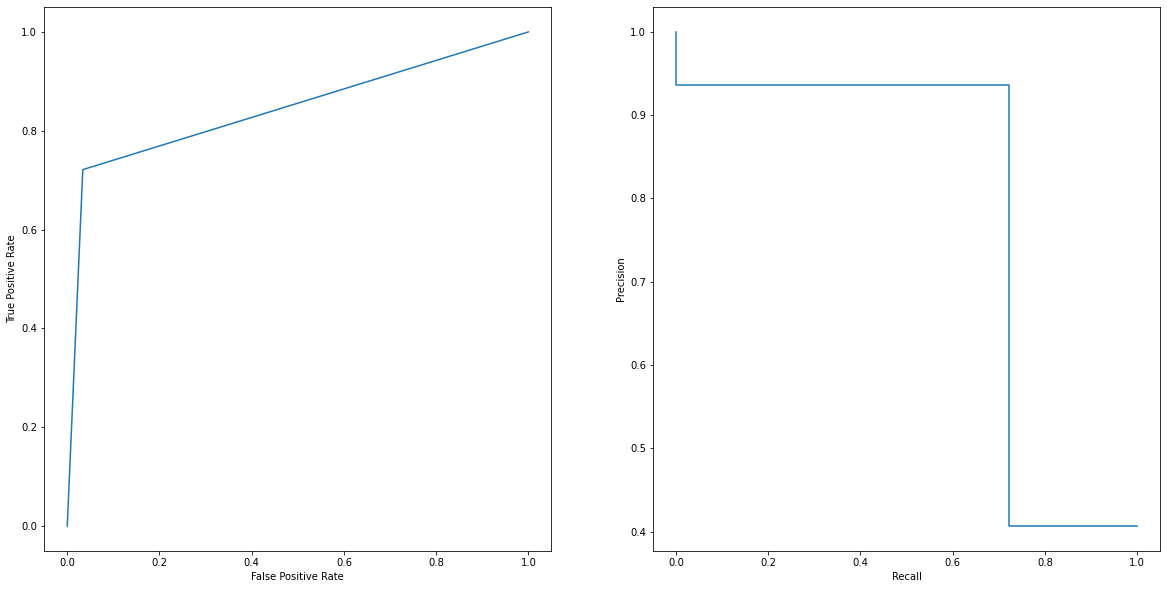

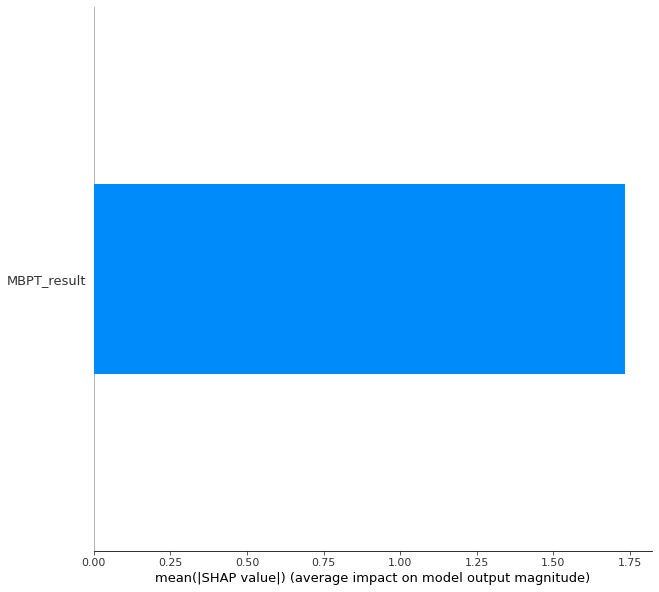

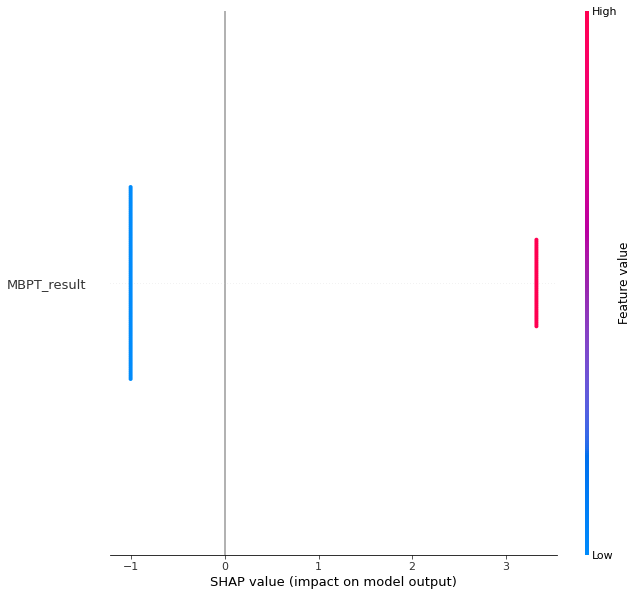

In [16]:
import xgboost as xgb

params = {'objective': "binary:logistic", 
          'eval_metric': 'logloss',
          'tree_method': 'gpu_hist', 
          'gpu_id': '0',
          'learning_rate': 0.001, 
          'max_depth': 5,
          'lambda': 3,
          'gamma': 0}

feature_mask = ['MBPT_result']

X_train = train_set[feature_mask].values
y_train = train_set['Asthma'].values
dtrain = xgb.DMatrix(X_train, label=y_train)

X_test = test_set[feature_mask].values
y_test = test_set['Asthma'].values
dtest = xgb.DMatrix(X_test, label=y_test)


model_xgb = xgb.train(params, dtrain, 
                    num_boost_round=20000, 
                    evals=[(dtest, 'test')], 
                    verbose_eval=0, 
                    early_stopping_rounds=1000)

print("Train accuracy", accuracy_score(y_train, model_xgb.predict(dtrain) > 0.5))
print("Test accuracy", accuracy_score(y_test, model_xgb.predict(dtest) > 0.5))
print("Train neg_loss : ", log_loss(y_pred=model_xgb.predict(dtrain), y_true=y_train))
print("Test neg_loss", log_loss(y_pred=model_xgb.predict(dtest), y_true=y_test))

y_hat = model_xgb.predict(dtest)

print(performances_hard_decision(y_test, y_hat, youden=True))

plot_roc_prc(y_hat, y_test)

explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=feature_mask, plot_size=(10, 10))

shap.summary_plot(shap_values, X_test, feature_names=feature_mask, plot_size=(10, 10))

## MBPT_result + PC20_16

In [17]:
import pickle
#### XGBoost
with open('./result/results_baseline_pc16.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)

columns = ['max_depth', 'learning_rate', 'lambda', 'gamma', 'val_scores', 'val_mse_loss', 'val_auroc', 'val_auprc', 'test_scores', 'test_mse_loss', 'test_auroc', 'test_auprc']

xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

baseline_pc16_metric = xg_best_param.copy()

display(xg_best_param.head(1))

,max_depth,learning_rate,lambda,gamma,val_scores,val_mse_loss,val_auroc,val_auprc,test_scores,test_mse_loss,test_auroc,test_auprc
0,3,0.001,3,0.0,0.858333,0.403638,0.829138,0.771809,0.86,0.40432,0.832013,0.765752


Train accuracy 0.8557046979865772
Test accuracy 0.86
Train neg_loss :  0.38777085338037887
Test neg_loss 0.3974438127626975
AUROC: 0.842
AUPRC: 0.870
specificity: 0.966
sensitivity: 0.721
PPV: 0.936
NPV: 0.835
f1: 0.815
accuracy: 0.867
threshold: 0.375
None


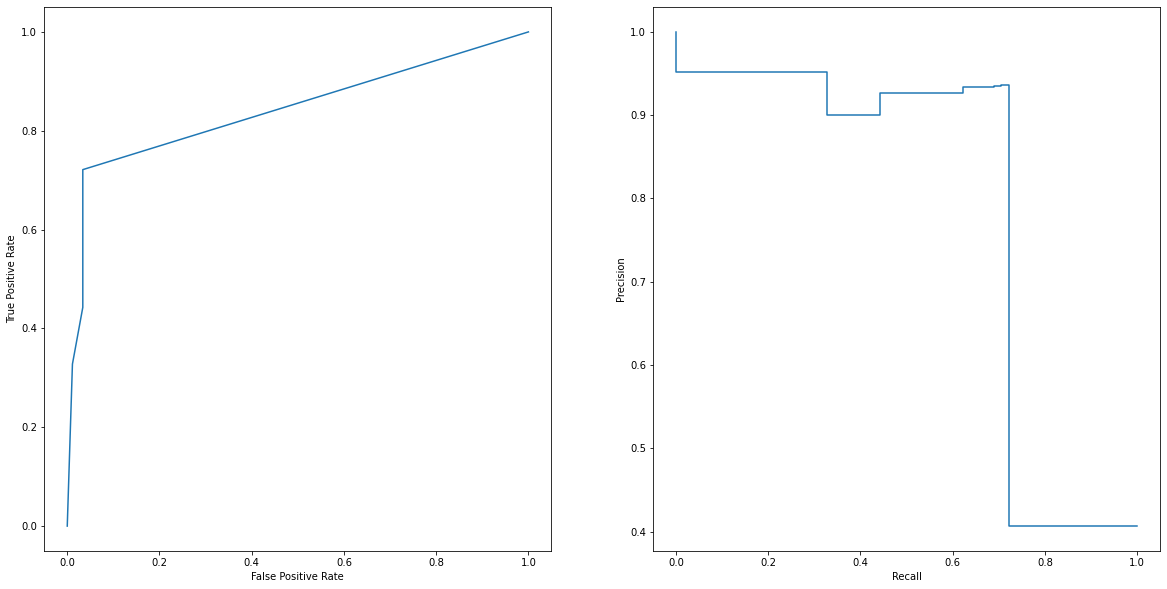

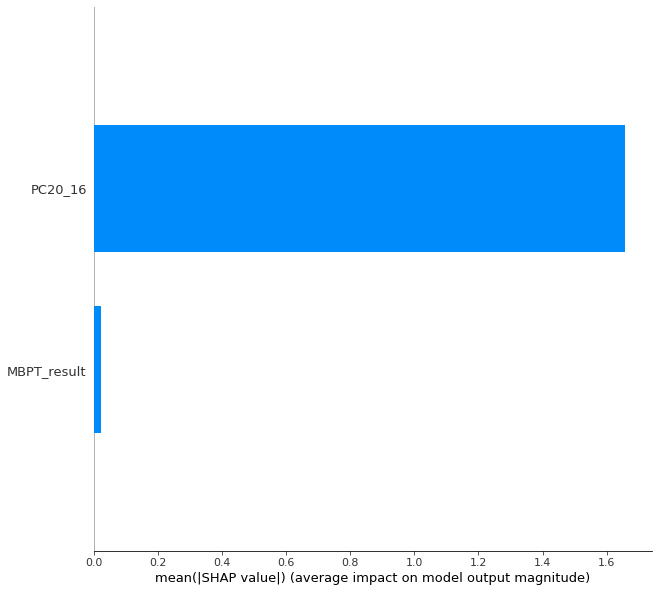

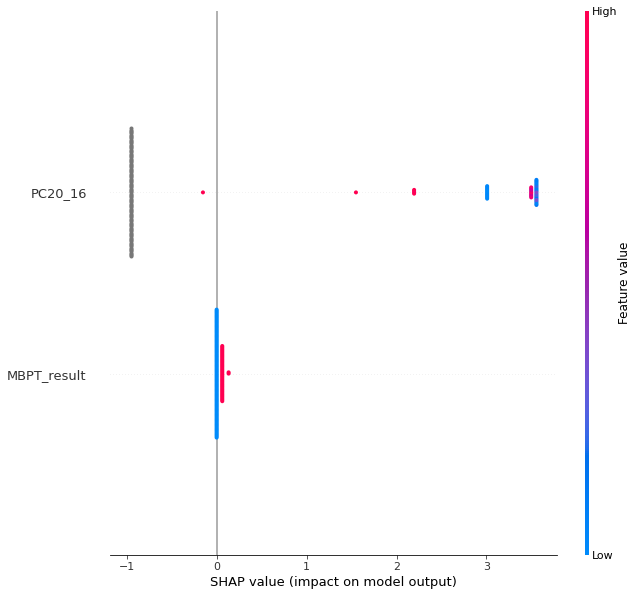

In [19]:
import xgboost as xgb

params = {'objective': "binary:logistic", 
          'eval_metric': 'logloss',
          'tree_method': 'gpu_hist', 
          'gpu_id': '0',
          'learning_rate': 0.001, 
          'max_depth': 3,
          'lambda': 3,
          'gamma': 0}

feature_mask = ['MBPT_result', 'PC20_16']

X_train = train_set[feature_mask].values
y_train = train_set['Asthma'].values
dtrain = xgb.DMatrix(X_train, label=y_train)

X_test = test_set[feature_mask].values
y_test = test_set['Asthma'].values
dtest = xgb.DMatrix(X_test, label=y_test)


model_xgb = xgb.train(params, dtrain, 
                    num_boost_round=20000, 
                    evals=[(dtest, 'test')], 
                    verbose_eval=0, 
                    early_stopping_rounds=1000)

print("Train accuracy", accuracy_score(y_train, model_xgb.predict(dtrain) > 0.5))
print("Test accuracy", accuracy_score(y_test, model_xgb.predict(dtest) > 0.5))
print("Train neg_loss : ", log_loss(y_pred=model_xgb.predict(dtrain), y_true=y_train))
print("Test neg_loss", log_loss(y_pred=model_xgb.predict(dtest), y_true=y_test))

y_hat = model_xgb.predict(dtest)

print(performances_hard_decision(y_test, y_hat, youden=True))

plot_roc_prc(y_hat, y_test)

explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=feature_mask, plot_size=(10, 10))

shap.summary_plot(shap_values, X_test, feature_names=feature_mask, plot_size=(10, 10))

## MBPT_result + PC20_32

In [20]:
import pickle
#### XGBoost
with open('./result/results_baseline_pc32.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)

columns = ['max_depth', 'learning_rate', 'lambda', 'gamma', 'val_scores', 'val_mse_loss', 'val_auroc', 'val_auprc', 'test_scores', 'test_mse_loss', 'test_auroc', 'test_auprc']

xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

baseline_pc32_metric = xg_best_param.copy()

display(xg_best_param.head(1))

FileNotFoundError: [Errno 2] No such file or directory: './result/results_baseline_pc32.pickle'

Train accuracy 0.8557046979865772
Test accuracy 0.86
Train neg_loss :  0.38777085338037887
Test neg_loss 0.3974438127626975
AUROC: 0.842
AUPRC: 0.870
specificity: 0.966
sensitivity: 0.721
PPV: 0.936
NPV: 0.835
f1: 0.815
accuracy: 0.867
threshold: 0.375
None


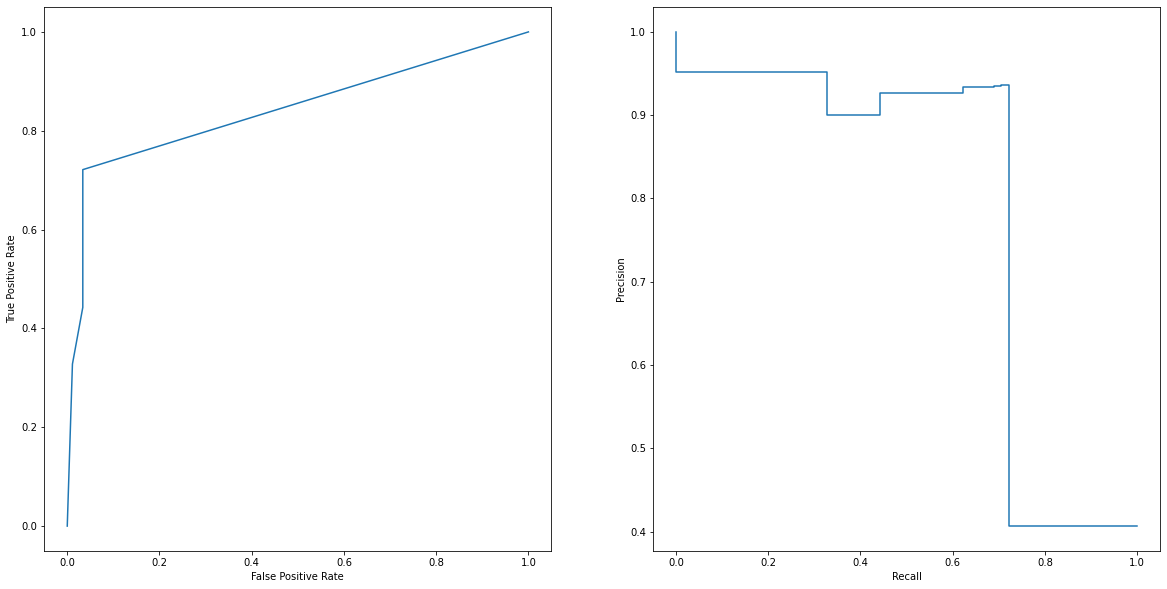

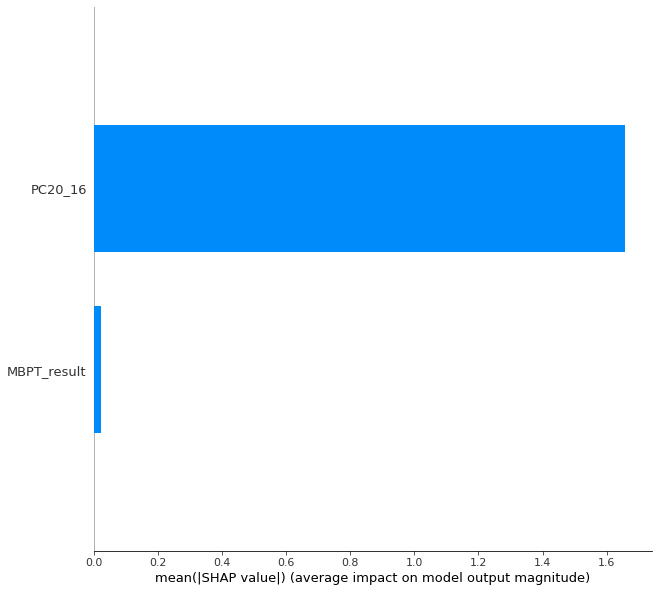

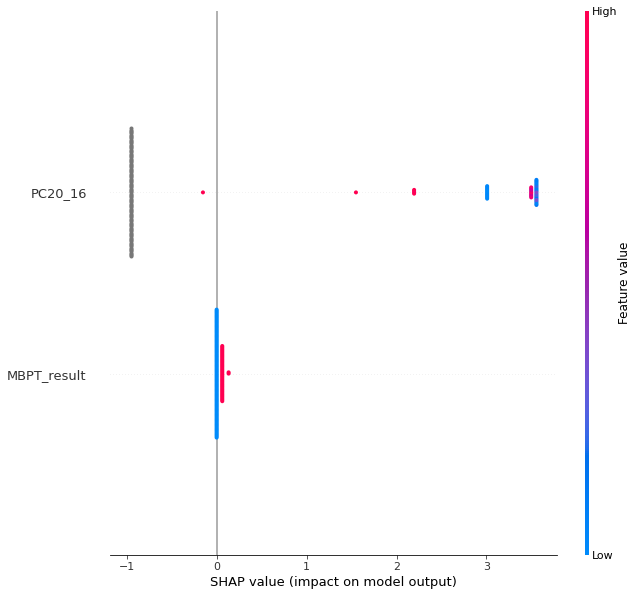

In [ ]:
import xgboost as xgb

params = {'objective': "binary:logistic", 
          'eval_metric': 'logloss',
          'tree_method': 'gpu_hist', 
          'gpu_id': '0',
          'learning_rate': 0.001, 
          'max_depth': 3,
          'lambda': 3,
          'gamma': 0}

feature_mask = ['MBPT_result', 'PC20_16']

X_train = train_set[feature_mask].values
y_train = train_set['Asthma'].values
dtrain = xgb.DMatrix(X_train, label=y_train)

X_test = test_set[feature_mask].values
y_test = test_set['Asthma'].values
dtest = xgb.DMatrix(X_test, label=y_test)


model_xgb = xgb.train(params, dtrain, 
                    num_boost_round=20000, 
                    evals=[(dtest, 'test')], 
                    verbose_eval=0, 
                    early_stopping_rounds=1000)

print("Train accuracy", accuracy_score(y_train, model_xgb.predict(dtrain) > 0.5))
print("Test accuracy", accuracy_score(y_test, model_xgb.predict(dtest) > 0.5))
print("Train neg_loss : ", log_loss(y_pred=model_xgb.predict(dtrain), y_true=y_train))
print("Test neg_loss", log_loss(y_pred=model_xgb.predict(dtest), y_true=y_test))

y_hat = model_xgb.predict(dtest)

print(performances_hard_decision(y_test, y_hat, youden=True))

plot_roc_prc(y_hat, y_test)

explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=feature_mask, plot_size=(10, 10))

shap.summary_plot(shap_values, X_test, feature_names=feature_mask, plot_size=(10, 10))

## MBPT_result + FeNO

In [ ]:
import pickle
#### XGBoost
with open('./result/results_baseline_FeNO.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)

columns = ['max_depth', 'learning_rate', 'lambda', 'gamma', 'val_scores', 'val_mse_loss', 'val_auroc', 'val_auprc', 'test_scores', 'test_mse_loss', 'test_auroc', 'test_auprc']

xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

baseline_feno_metric = xg_best_param.copy()

display(xg_best_param.head(1))

,max_depth,learning_rate,lambda,gamma,val_scores,val_mse_loss,val_auroc,val_auprc,test_scores,test_mse_loss,test_auroc,test_auprc
0,3,0.001,3,0.0,0.858333,0.403638,0.829138,0.771809,0.86,0.40432,0.832013,0.765752


Train accuracy 0.8557046979865772
Test accuracy 0.86
Train neg_loss :  0.38777085338037887
Test neg_loss 0.3974438127626975
AUROC: 0.842
AUPRC: 0.870
specificity: 0.966
sensitivity: 0.721
PPV: 0.936
NPV: 0.835
f1: 0.815
accuracy: 0.867
threshold: 0.375
None


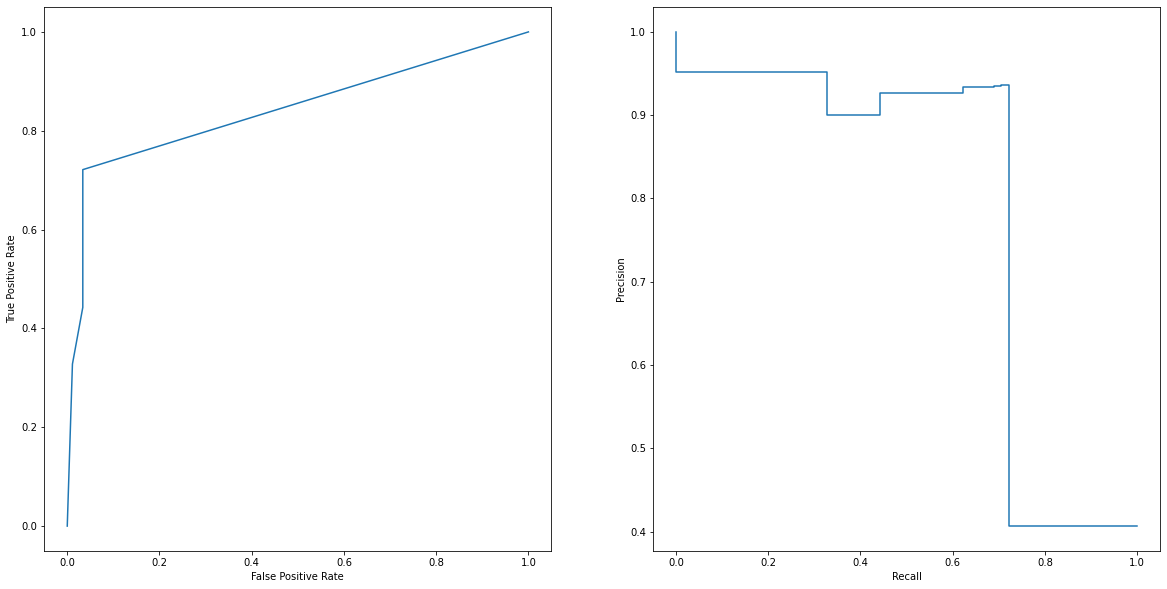

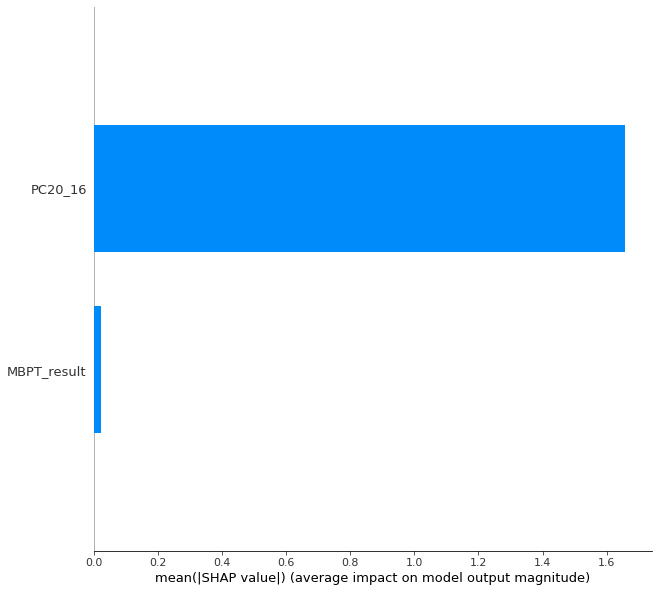

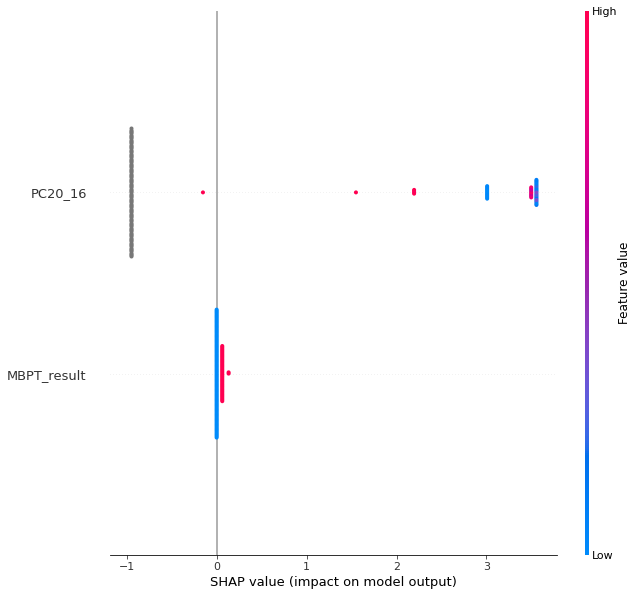

In [ ]:
import xgboost as xgb

params = {'objective': "binary:logistic", 
          'eval_metric': 'logloss',
          'tree_method': 'gpu_hist', 
          'gpu_id': '0',
          'learning_rate': 0.001, 
          'max_depth': 3,
          'lambda': 3,
          'gamma': 0}

feature_mask = ['MBPT_result', 'PC20_16']

X_train = train_set[feature_mask].values
y_train = train_set['Asthma'].values
dtrain = xgb.DMatrix(X_train, label=y_train)

X_test = test_set[feature_mask].values
y_test = test_set['Asthma'].values
dtest = xgb.DMatrix(X_test, label=y_test)


model_xgb = xgb.train(params, dtrain, 
                    num_boost_round=20000, 
                    evals=[(dtest, 'test')], 
                    verbose_eval=0, 
                    early_stopping_rounds=1000)

print("Train accuracy", accuracy_score(y_train, model_xgb.predict(dtrain) > 0.5))
print("Test accuracy", accuracy_score(y_test, model_xgb.predict(dtest) > 0.5))
print("Train neg_loss : ", log_loss(y_pred=model_xgb.predict(dtrain), y_true=y_train))
print("Test neg_loss", log_loss(y_pred=model_xgb.predict(dtest), y_true=y_test))

y_hat = model_xgb.predict(dtest)

print(performances_hard_decision(y_test, y_hat, youden=True))

plot_roc_prc(y_hat, y_test)

explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=feature_mask, plot_size=(10, 10))

shap.summary_plot(shap_values, X_test, feature_names=feature_mask, plot_size=(10, 10))

## MBPT_result + ISE_Eos

In [21]:
import pickle
#### XGBoost
with open('./result/results_baseline_ISE.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)

columns = ['max_depth', 'learning_rate', 'lambda', 'gamma', 'val_scores', 'val_mse_loss', 'val_auroc', 'val_auprc', 'test_scores', 'test_mse_loss', 'test_auroc', 'test_auprc']

xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

baseline_ise_metric = xg_best_param.copy()

display(xg_best_param.head(1))

,max_depth,learning_rate,lambda,gamma,val_scores,val_mse_loss,val_auroc,val_auprc,test_scores,test_mse_loss,test_auroc,test_auprc
0,1,0.001,3,0.0,0.775,0.498461,0.802951,0.769671,0.866667,0.342473,0.912507,0.894672


Train accuracy 0.8741610738255033
Test accuracy 0.88
Train neg_loss :  0.3325506062028092
Test neg_loss 0.32628148048184813
AUROC: 0.926
AUPRC: 0.921
specificity: 0.910
sensitivity: 0.836
PPV: 0.864
NPV: 0.890
f1: 0.850
accuracy: 0.880
threshold: 0.516
None


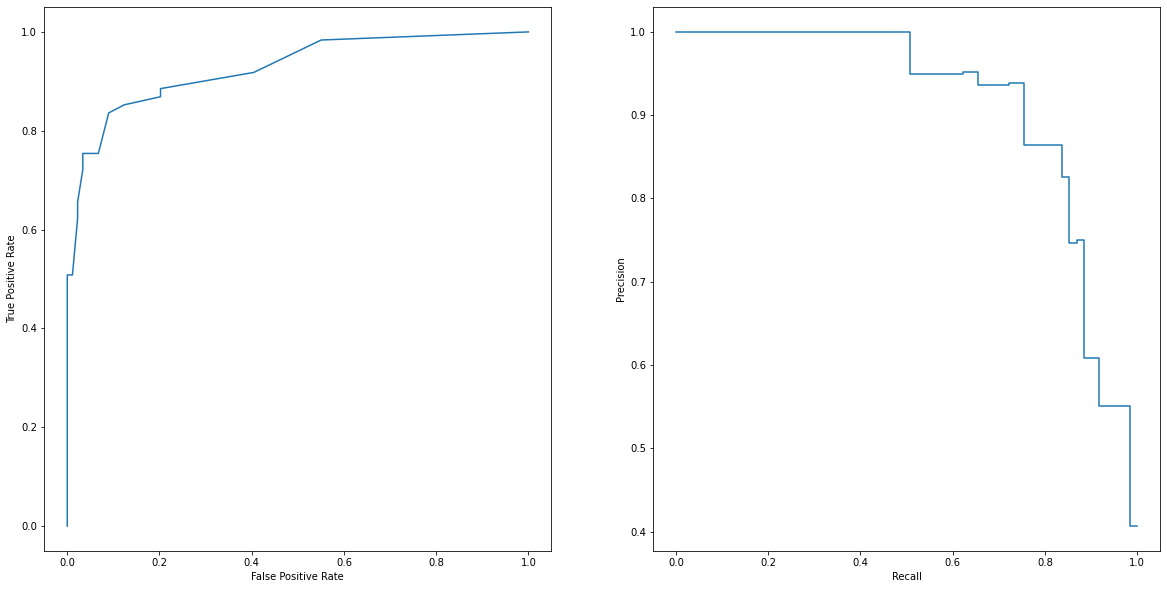

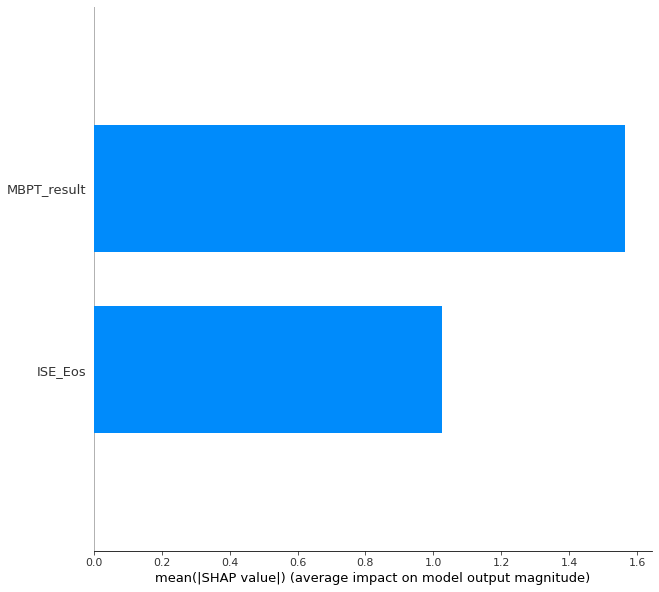

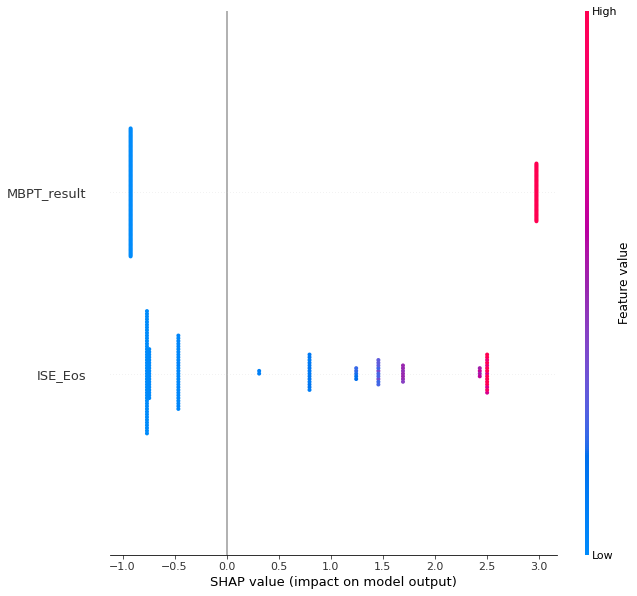

In [23]:
import xgboost as xgb

params = {'objective': "binary:logistic", 
          'eval_metric': 'logloss',
          'tree_method': 'gpu_hist', 
          'gpu_id': '0',
          'learning_rate': 0.001, 
          'max_depth': 1,
          'lambda': 3,
          'gamma': 0}

feature_mask = ['MBPT_result', 'ISE_Eos']

X_train = train_set[feature_mask].values
y_train = train_set['Asthma'].values
dtrain = xgb.DMatrix(X_train, label=y_train)

X_test = test_set[feature_mask].values
y_test = test_set['Asthma'].values
dtest = xgb.DMatrix(X_test, label=y_test)


model_xgb = xgb.train(params, dtrain, 
                    num_boost_round=20000, 
                    evals=[(dtest, 'test')], 
                    verbose_eval=0, 
                    early_stopping_rounds=1000)

print("Train accuracy", accuracy_score(y_train, model_xgb.predict(dtrain) > 0.5))
print("Test accuracy", accuracy_score(y_test, model_xgb.predict(dtest) > 0.5))
print("Train neg_loss : ", log_loss(y_pred=model_xgb.predict(dtrain), y_true=y_train))
print("Test neg_loss", log_loss(y_pred=model_xgb.predict(dtest), y_true=y_test))

y_hat = model_xgb.predict(dtest)

print(performances_hard_decision(y_test, y_hat, youden=True))

plot_roc_prc(y_hat, y_test)

explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=feature_mask, plot_size=(10, 10))

shap.summary_plot(shap_values, X_test, feature_names=feature_mask, plot_size=(10, 10))

## MBPT_result + ISE_Eo3%

In [26]:
import pickle
#### XGBoost
with open('./result/results_baseline_ISE_3.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)

columns = ['max_depth', 'learning_rate', 'lambda', 'gamma', 'val_scores', 'val_mse_loss', 'val_auroc', 'val_auprc', 'test_scores', 'test_mse_loss', 'test_auroc', 'test_auprc']

xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

baseline_ise_3_metric = xg_best_param.copy()

display(xg_best_param.head(1))

,max_depth,learning_rate,lambda,gamma,val_scores,val_mse_loss,val_auroc,val_auprc,test_scores,test_mse_loss,test_auroc,test_auprc
0,1,0.001,2,0.0,0.875,0.337119,0.891493,0.864706,0.866667,0.342113,0.904034,0.861445


Train accuracy 0.8540268456375839
Test accuracy 0.8666666666666667
Train neg_loss :  0.3459483656294694
Test neg_loss 0.3410082189117869
AUROC: 0.904
AUPRC: 0.908
specificity: 0.966
sensitivity: 0.721
PPV: 0.936
NPV: 0.835
f1: 0.815
accuracy: 0.867
threshold: 0.865
None


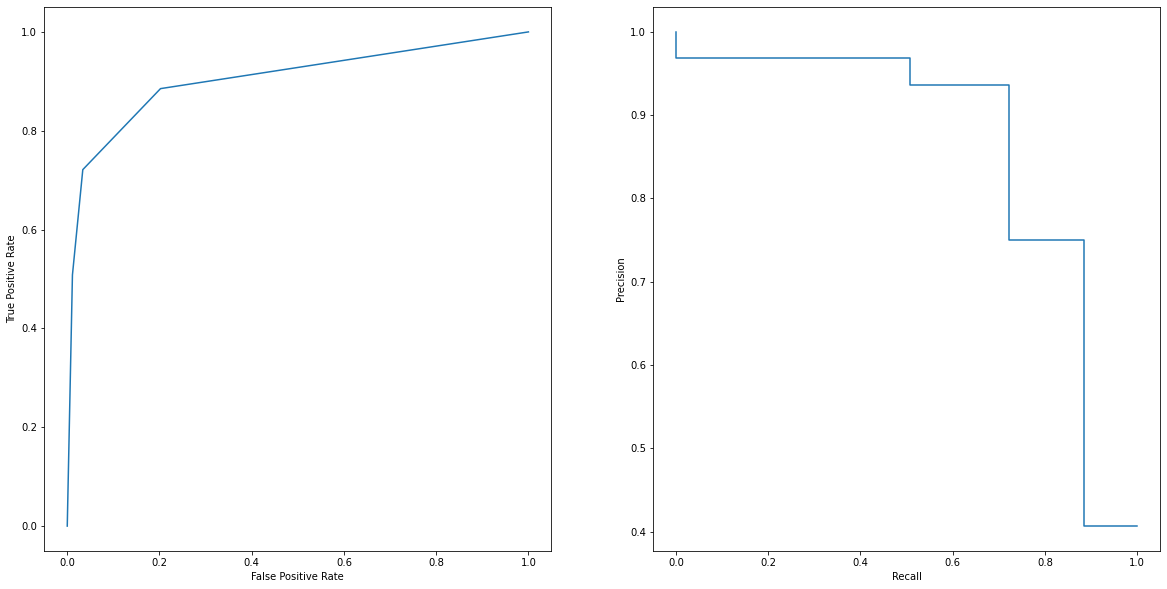

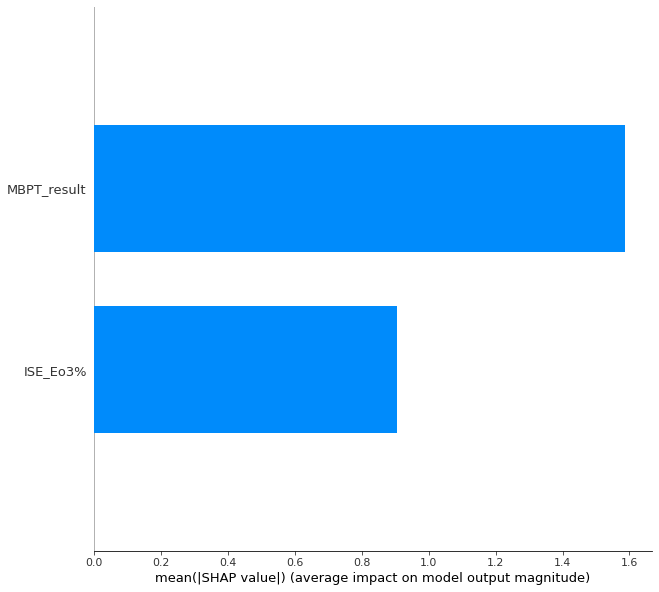

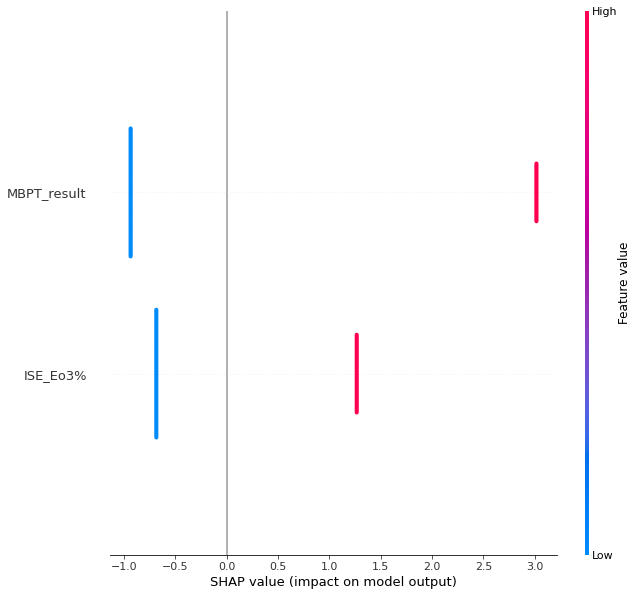

In [27]:
import xgboost as xgb

params = {'objective': "binary:logistic", 
          'eval_metric': 'logloss',
          'tree_method': 'gpu_hist', 
          'gpu_id': '0',
          'learning_rate': 0.001, 
          'max_depth': 1,
          'lambda': 2,
          'gamma': 0}

feature_mask = ['MBPT_result', 'ISE_Eo3%']

X_train = train_set[feature_mask].values
y_train = train_set['Asthma'].values
dtrain = xgb.DMatrix(X_train, label=y_train)

X_test = test_set[feature_mask].values
y_test = test_set['Asthma'].values
dtest = xgb.DMatrix(X_test, label=y_test)


model_xgb = xgb.train(params, dtrain, 
                    num_boost_round=20000, 
                    evals=[(dtest, 'test')], 
                    verbose_eval=0, 
                    early_stopping_rounds=1000)

print("Train accuracy", accuracy_score(y_train, model_xgb.predict(dtrain) > 0.5))
print("Test accuracy", accuracy_score(y_test, model_xgb.predict(dtest) > 0.5))
print("Train neg_loss : ", log_loss(y_pred=model_xgb.predict(dtrain), y_true=y_train))
print("Test neg_loss", log_loss(y_pred=model_xgb.predict(dtest), y_true=y_test))

y_hat = model_xgb.predict(dtest)

print(performances_hard_decision(y_test, y_hat, youden=True))

plot_roc_prc(y_hat, y_test)

explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=feature_mask, plot_size=(10, 10))

shap.summary_plot(shap_values, X_test, feature_names=feature_mask, plot_size=(10, 10))

## MBPT_result + FeNO + ISE

In [28]:
import pickle
#### XGBoost
with open('./result/results_baseline_FeNO_ISE.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)

columns = ['max_depth', 'learning_rate', 'lambda', 'gamma', 'val_scores', 'val_mse_loss', 'val_auroc', 'val_auprc', 'test_scores', 'test_mse_loss', 'test_auroc', 'test_auprc']

xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

baseline_feno_ise_metric = xg_best_param.copy()

display(xg_best_param.head(1))

,max_depth,learning_rate,lambda,gamma,val_scores,val_mse_loss,val_auroc,val_auprc,test_scores,test_mse_loss,test_auroc,test_auprc
0,1,0.001,2,0.0,0.875,0.313515,0.916811,0.916943,0.873333,0.332371,0.921809,0.91891


Train accuracy 0.8859060402684564
Test accuracy 0.88
Train neg_loss :  0.31426800965900287
Test neg_loss 0.336862629186362
AUROC: 0.918
AUPRC: 0.917
specificity: 0.933
sensitivity: 0.820
PPV: 0.893
NPV: 0.883
f1: 0.855
accuracy: 0.887
threshold: 0.665
None


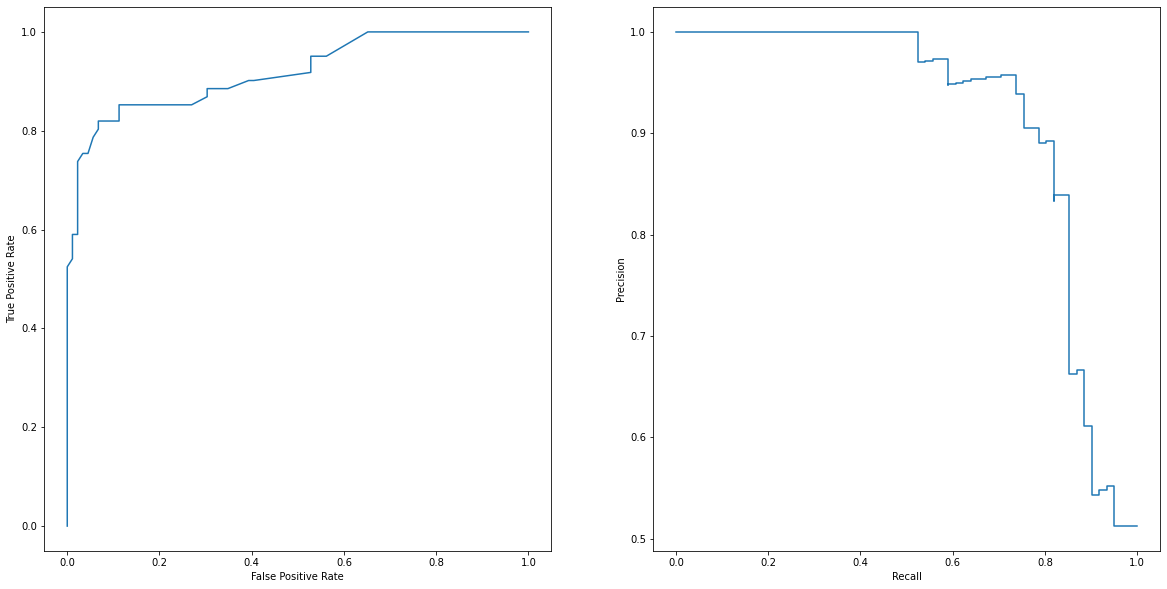

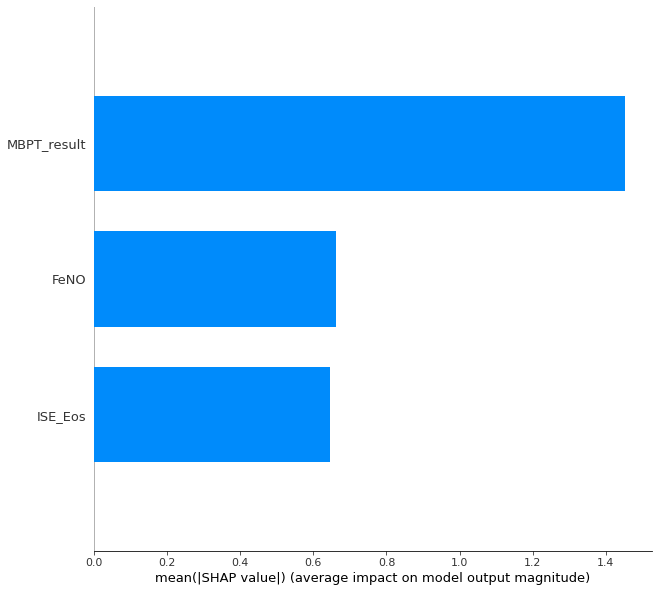

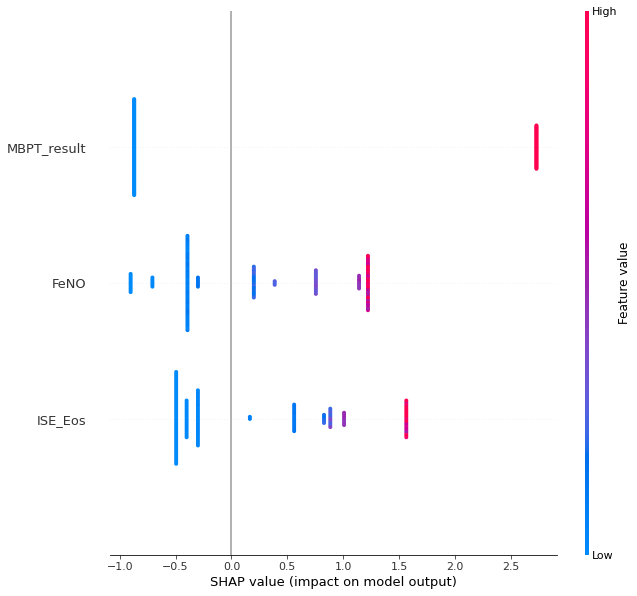

In [29]:
import xgboost as xgb

params = {'objective': "binary:logistic", 
          'eval_metric': 'logloss',
          'tree_method': 'gpu_hist', 
          'gpu_id': '0',
          'learning_rate': 0.001, 
          'max_depth': 1,
          'lambda': 2,
          'gamma': 0}

feature_mask = ['MBPT_result', 'FeNO', 'ISE_Eos']

X_train = train_set[feature_mask].values
y_train = train_set['Asthma'].values
dtrain = xgb.DMatrix(X_train, label=y_train)

X_test = test_set[feature_mask].values
y_test = test_set['Asthma'].values
dtest = xgb.DMatrix(X_test, label=y_test)


model_xgb = xgb.train(params, dtrain, 
                    num_boost_round=20000, 
                    evals=[(dtest, 'test')], 
                    verbose_eval=0, 
                    early_stopping_rounds=1000)

print("Train accuracy", accuracy_score(y_train, model_xgb.predict(dtrain) > 0.5))
print("Test accuracy", accuracy_score(y_test, model_xgb.predict(dtest) > 0.5))
print("Train neg_loss : ", log_loss(y_pred=model_xgb.predict(dtrain), y_true=y_train))
print("Test neg_loss", log_loss(y_pred=model_xgb.predict(dtest), y_true=y_test))

y_hat = model_xgb.predict(dtest)

print(performances_hard_decision(y_test, y_hat, youden=True))

plot_roc_prc(y_hat, y_test)

explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=feature_mask, plot_size=(10, 10))

shap.summary_plot(shap_values, X_test, feature_names=feature_mask, plot_size=(10, 10))

## MBPT_result + FeNO + ISE_Eo3%

In [30]:
import pickle
#### XGBoost
with open('./result/results_baseline_FeNO_ISE_3.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)

columns = ['max_depth', 'learning_rate', 'lambda', 'gamma', 'val_scores', 'val_mse_loss', 'val_auroc', 'val_auprc', 'test_scores', 'test_mse_loss', 'test_auroc', 'test_auprc']

xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

baseline_feno_ise_3_metric = xg_best_param.copy()

display(xg_best_param.head(1))

,max_depth,learning_rate,lambda,gamma,val_scores,val_mse_loss,val_auroc,val_auprc,test_scores,test_mse_loss,test_auroc,test_auprc
0,1,0.001,1,0.0,0.866667,0.360327,0.915075,0.884188,0.873333,0.343906,0.912691,0.902401


Train accuracy 0.8825503355704698
Test accuracy 0.8733333333333333
Train neg_loss :  0.3221268627680088
Test neg_loss 0.3448001632715265
AUROC: 0.914
AUPRC: 0.912
specificity: 0.921
sensitivity: 0.820
PPV: 0.877
NPV: 0.882
f1: 0.847
accuracy: 0.880
threshold: 0.607
None


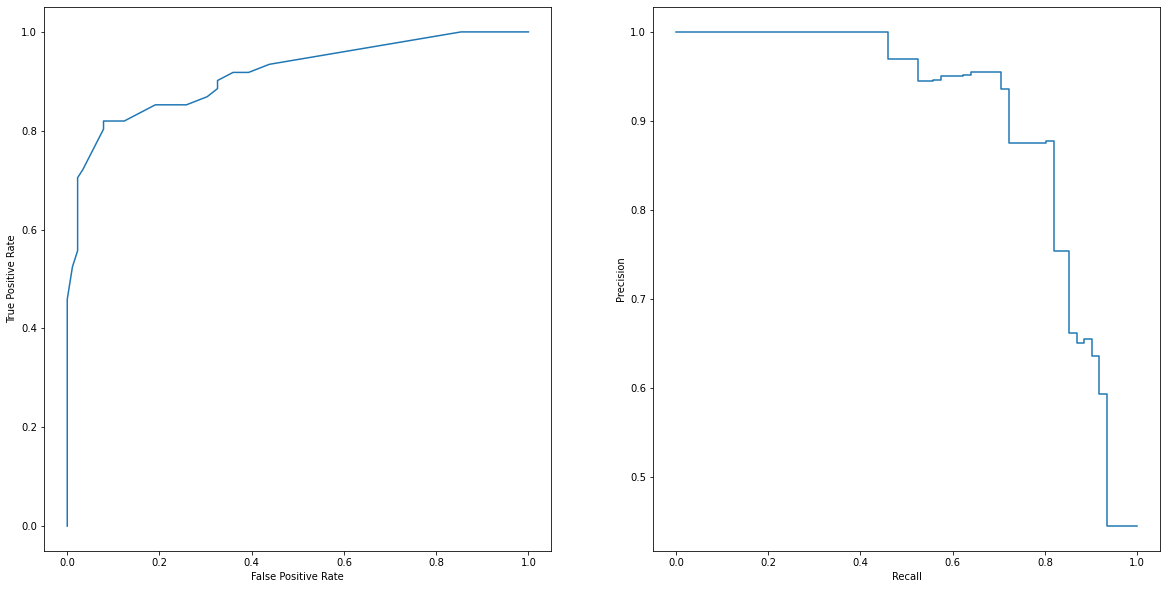

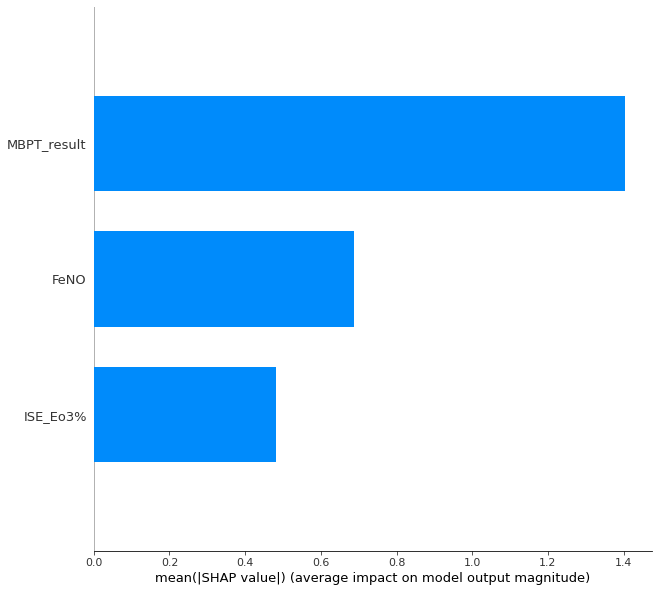

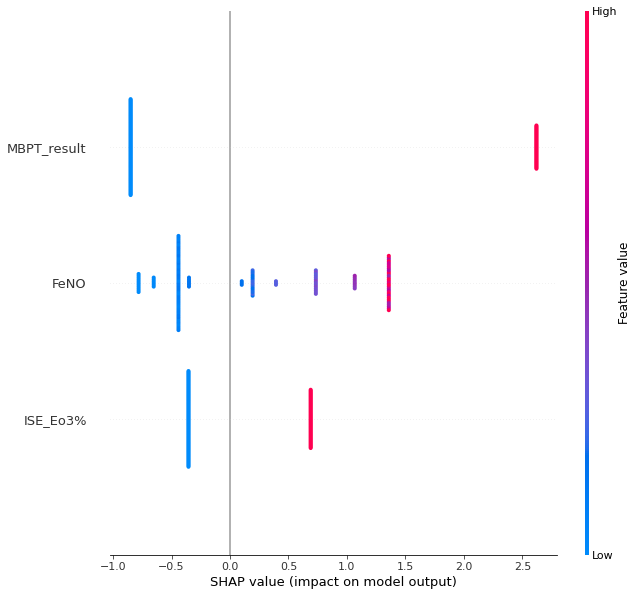

In [31]:
import xgboost as xgb

params = {'objective': "binary:logistic", 
          'eval_metric': 'logloss',
          'tree_method': 'gpu_hist', 
          'gpu_id': '0',
          'learning_rate': 0.001, 
          'max_depth': 1,
          'lambda': 1,
          'gamma': 0}

feature_mask = ['MBPT_result', 'FeNO', 'ISE_Eo3%']

X_train = train_set[feature_mask].values
y_train = train_set['Asthma'].values
dtrain = xgb.DMatrix(X_train, label=y_train)

X_test = test_set[feature_mask].values
y_test = test_set['Asthma'].values
dtest = xgb.DMatrix(X_test, label=y_test)


model_xgb = xgb.train(params, dtrain, 
                    num_boost_round=20000, 
                    evals=[(dtest, 'test')], 
                    verbose_eval=0, 
                    early_stopping_rounds=1000)

print("Train accuracy", accuracy_score(y_train, model_xgb.predict(dtrain) > 0.5))
print("Test accuracy", accuracy_score(y_test, model_xgb.predict(dtest) > 0.5))
print("Train neg_loss : ", log_loss(y_pred=model_xgb.predict(dtrain), y_true=y_train))
print("Test neg_loss", log_loss(y_pred=model_xgb.predict(dtest), y_true=y_test))

y_hat = model_xgb.predict(dtest)

print(performances_hard_decision(y_test, y_hat, youden=True))

plot_roc_prc(y_hat, y_test)

explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=feature_mask, plot_size=(10, 10))

shap.summary_plot(shap_values, X_test, feature_names=feature_mask, plot_size=(10, 10))

## MBPT_result + maxFall_FEV1_p + PC20_32 

In [32]:
import pickle
#### XGBoost
with open('./result/results_baseline_dr.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)

columns = ['max_depth', 'learning_rate', 'lambda', 'gamma', 'val_scores', 'val_mse_loss', 'val_auroc', 'val_auprc', 'test_scores', 'test_mse_loss', 'test_auroc', 'test_auprc']

xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

baseline_dr_metric = xg_best_param.copy()

display(xg_best_param.head(1))

,max_depth,learning_rate,lambda,gamma,val_scores,val_mse_loss,val_auroc,val_auprc,test_scores,test_mse_loss,test_auroc,test_auprc
0,1,0.001,2,0.3,0.8,0.424754,0.849826,0.824161,0.886667,0.347694,0.908086,0.850734


Train accuracy 0.8708053691275168
Test accuracy 0.88
Train neg_loss :  0.33356762552421365
Test neg_loss 0.3505001648763816
AUROC: 0.907
AUPRC: 0.880
specificity: 0.944
sensitivity: 0.820
PPV: 0.909
NPV: 0.884
f1: 0.862
accuracy: 0.893
threshold: 0.307
None


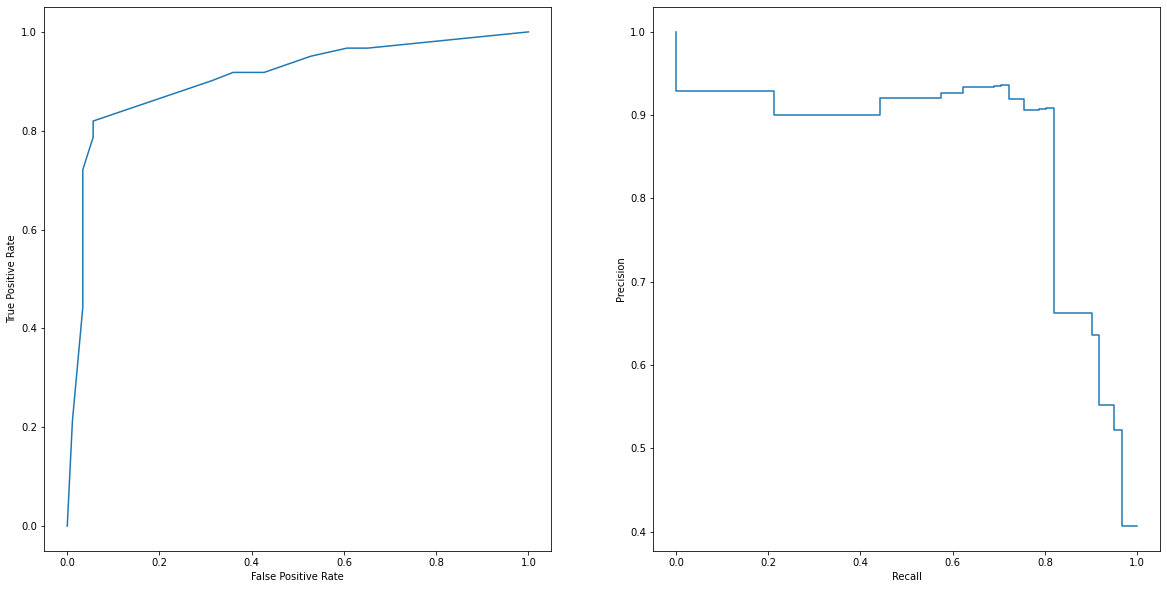

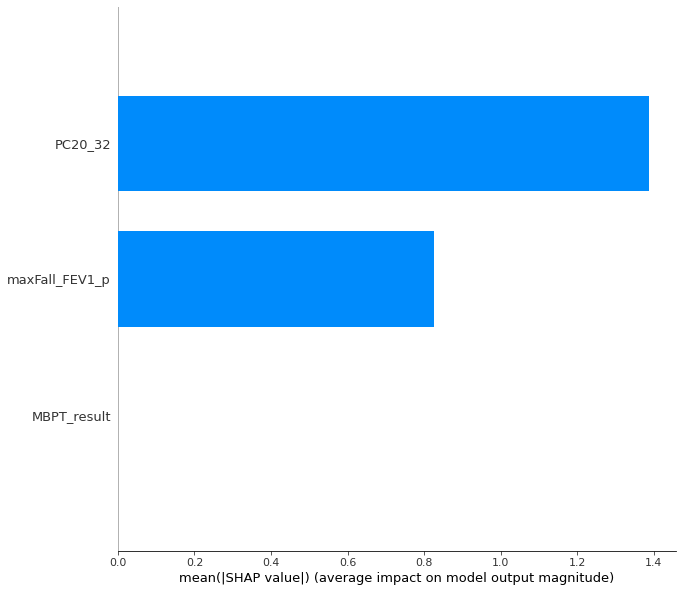

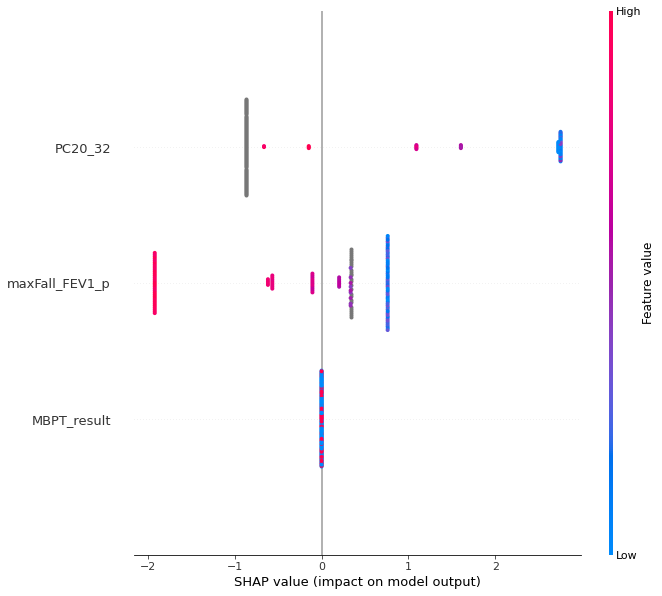

In [34]:
import xgboost as xgb

params = {'objective': "binary:logistic", 
          'eval_metric': 'logloss',
          'tree_method': 'gpu_hist', 
          'gpu_id': '0',
          'learning_rate': 0.001, 
          'max_depth': 1,
          'lambda': 2,
          'gamma': 0.3}

feature_mask = ['MBPT_result', 'maxFall_FEV1_p', 'PC20_32']

X_train = train_set[feature_mask].values
y_train = train_set['Asthma'].values
dtrain = xgb.DMatrix(X_train, label=y_train)

X_test = test_set[feature_mask].values
y_test = test_set['Asthma'].values
dtest = xgb.DMatrix(X_test, label=y_test)


model_xgb = xgb.train(params, dtrain, 
                    num_boost_round=20000, 
                    evals=[(dtest, 'test')], 
                    verbose_eval=0, 
                    early_stopping_rounds=1000)

print("Train accuracy", accuracy_score(y_train, model_xgb.predict(dtrain) > 0.5))
print("Test accuracy", accuracy_score(y_test, model_xgb.predict(dtest) > 0.5))
print("Train neg_loss : ", log_loss(y_pred=model_xgb.predict(dtrain), y_true=y_train))
print("Test neg_loss", log_loss(y_pred=model_xgb.predict(dtest), y_true=y_test))

y_hat = model_xgb.predict(dtest)

print(performances_hard_decision(y_test, y_hat, youden=True))

plot_roc_prc(y_hat, y_test)

explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=feature_mask, plot_size=(10, 10))

shap.summary_plot(shap_values, X_test, feature_names=feature_mask, plot_size=(10, 10))

## MBPT_text

In [40]:
import pickle
#### XGBoost
with open('./result/results_mbpt_txt.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)

columns = ['max_depth', 'learning_rate', 'lambda', 'gamma', 'val_scores', 'val_mse_loss', 'val_auroc', 'val_auprc', 'test_scores', 'test_mse_loss', 'test_auroc', 'test_auprc']

xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

mbpt_txt_metric = xg_best_param.copy()

display(xg_best_param.head(1))

,max_depth,learning_rate,lambda,gamma,val_scores,val_mse_loss,val_auroc,val_auprc,test_scores,test_mse_loss,test_auroc,test_auprc
0,2,0.001,3,0.0,0.858333,0.385925,0.889034,0.879736,0.86,0.359279,0.916099,0.896192


Train accuracy 0.9345637583892618
Test accuracy 0.86
Train neg_loss :  0.1969056902016746
Test neg_loss 0.35942757403322806
AUROC: 0.920
AUPRC: 0.900
specificity: 0.876
sensitivity: 0.852
PPV: 0.825
NPV: 0.897
f1: 0.839
accuracy: 0.867
threshold: 0.382
None


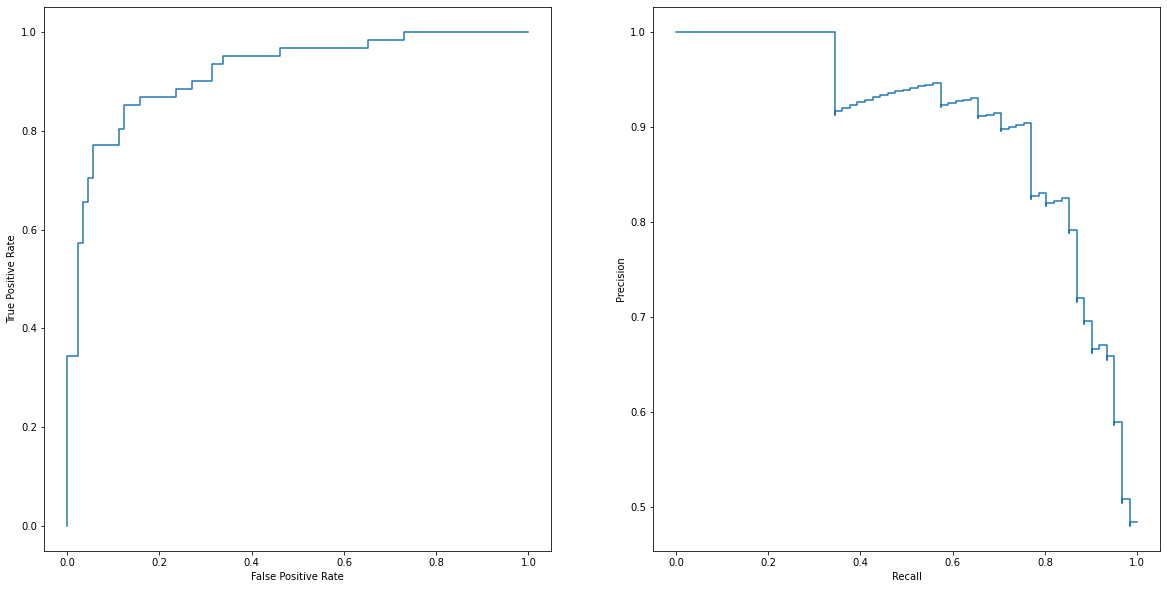

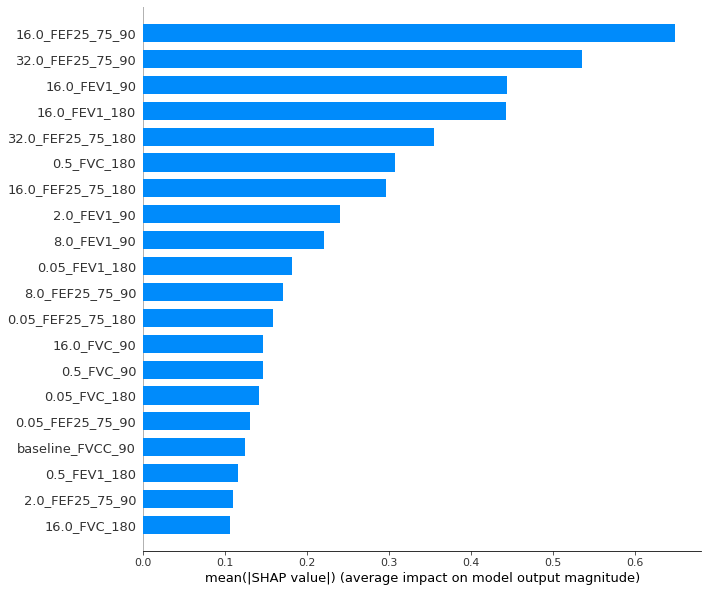

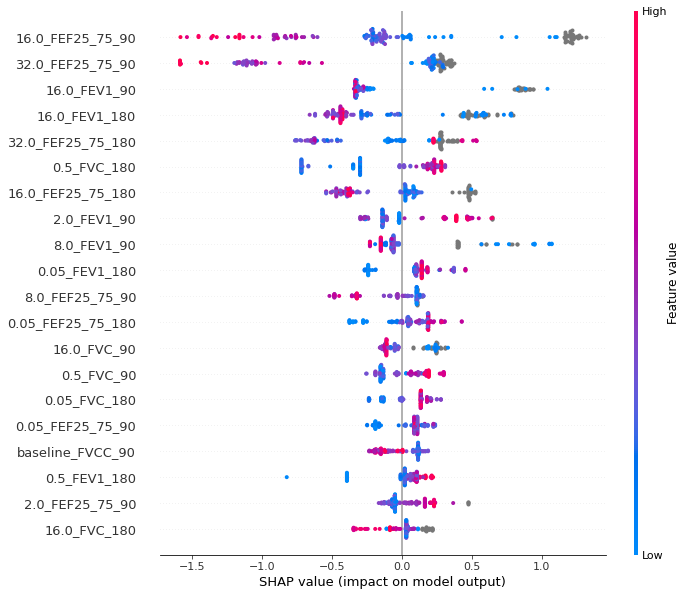

In [41]:
import xgboost as xgb
import re

params = {'objective': "binary:logistic", 
          'eval_metric': 'logloss',
          'tree_method': 'gpu_hist', 
          'gpu_id': '0',
          'learning_rate': 0.001, 
          'max_depth': 2,
          'lambda': 3,
          'gamma': 0.0}

baseline_txt = [i for i in df_init.columns if "baseline" in i]
subs = r"0.05|0.5|2.0|8.0|16.0|32.0"
mbpt_txt = [x for x in df_init.columns if re.search(subs, str(x))]

feature_mask = baseline_txt + mbpt_txt

X_train = train_set[feature_mask].values
y_train = train_set['Asthma'].values
dtrain = xgb.DMatrix(X_train, label=y_train)

X_test = test_set[feature_mask].values
y_test = test_set['Asthma'].values
dtest = xgb.DMatrix(X_test, label=y_test)


model_xgb = xgb.train(params, dtrain, 
                    num_boost_round=20000, 
                    evals=[(dtest, 'test')], 
                    verbose_eval=0, 
                    early_stopping_rounds=1000)

print("Train accuracy", accuracy_score(y_train, model_xgb.predict(dtrain) > 0.5))
print("Test accuracy", accuracy_score(y_test, model_xgb.predict(dtest) > 0.5))
print("Train neg_loss : ", log_loss(y_pred=model_xgb.predict(dtrain), y_true=y_train))
print("Test neg_loss", log_loss(y_pred=model_xgb.predict(dtest), y_true=y_test))

y_hat = model_xgb.predict(dtest)

print(performances_hard_decision(y_test, y_hat, youden=True))

plot_roc_prc(y_hat, y_test)

explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=feature_mask, plot_size=(10, 10))

shap.summary_plot(shap_values, X_test, feature_names=feature_mask, plot_size=(10, 10))

## MBPT_result + maxFall_FEV1_p + PC20_32  + MBPT_text

In [42]:
import pickle
#### XGBoost
with open('./result/results_mbpt_txt_baseline.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)

columns = ['max_depth', 'learning_rate', 'lambda', 'gamma', 'val_scores', 'val_mse_loss', 'val_auroc', 'val_auprc', 'test_scores', 'test_mse_loss', 'test_auroc', 'test_auprc']

xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

mbpt_txt_dr_metric = xg_best_param.copy()

display(xg_best_param.head(1))

,max_depth,learning_rate,lambda,gamma,val_scores,val_mse_loss,val_auroc,val_auprc,test_scores,test_mse_loss,test_auroc,test_auprc
0,1,0.001,3,0.2,0.841667,0.35539,0.895833,0.888936,0.886667,0.321216,0.92448,0.911346


Train accuracy 0.8657718120805369
Test accuracy 0.88
Train neg_loss :  0.30237429600596527
Test neg_loss 0.3252691472073396
AUROC: 0.925
AUPRC: 0.914
specificity: 0.933
sensitivity: 0.820
PPV: 0.893
NPV: 0.883
f1: 0.855
accuracy: 0.887
threshold: 0.375
None


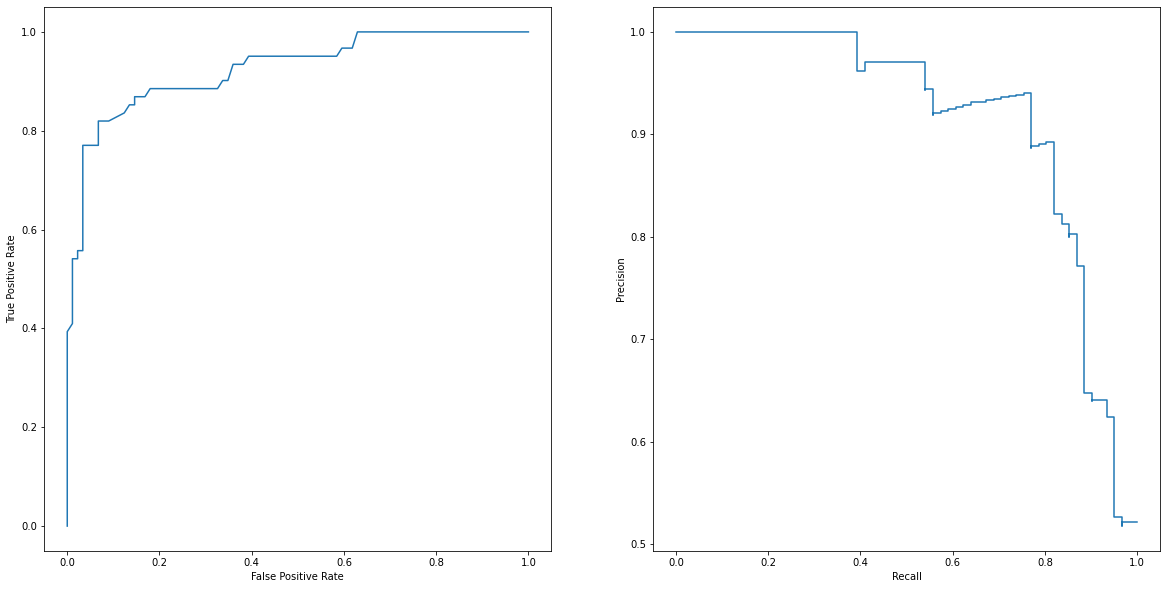

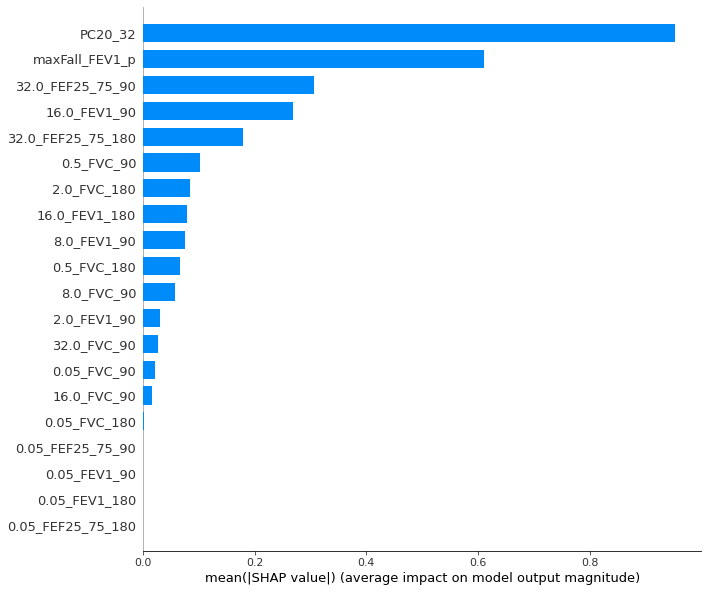

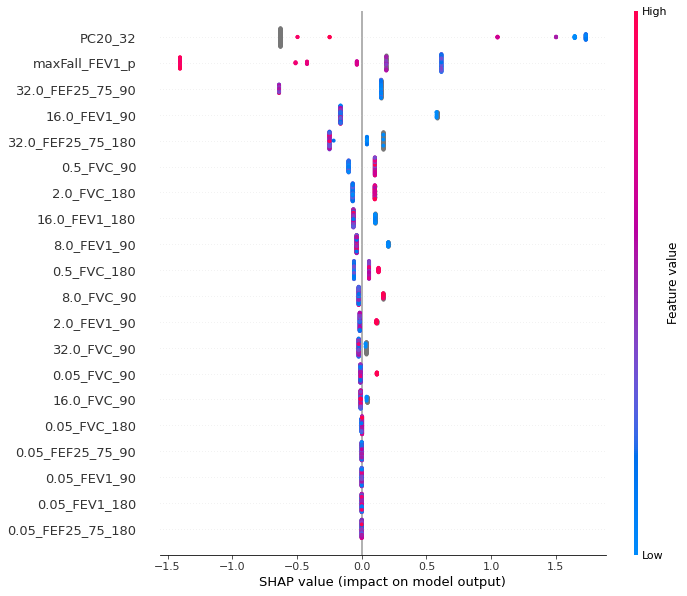

In [43]:
import xgboost as xgb
import re

params = {'objective': "binary:logistic", 
          'eval_metric': 'logloss',
          'tree_method': 'gpu_hist', 
          'gpu_id': '0',
          'learning_rate': 0.001, 
          'max_depth': 1,
          'lambda': 3,
          'gamma': 0.2}

baseline = ['MBPT_result', 'maxFall_FEV1_p', 'PC20_32']
baseline_txt = [i for i in df_init.columns if "baseline" in i]
subs = r"0.05|0.5|2.0|8.0|16.0|32.0"
mbpt_txt = [x for x in df_init.columns if re.search(subs, str(x))]

feature_mask = baseline + baseline_txt + mbpt_txt

X_train = train_set[feature_mask].values
y_train = train_set['Asthma'].values
dtrain = xgb.DMatrix(X_train, label=y_train)

X_test = test_set[feature_mask].values
y_test = test_set['Asthma'].values
dtest = xgb.DMatrix(X_test, label=y_test)


model_xgb = xgb.train(params, dtrain, 
                    num_boost_round=20000, 
                    evals=[(dtest, 'test')], 
                    verbose_eval=0, 
                    early_stopping_rounds=1000)

print("Train accuracy", accuracy_score(y_train, model_xgb.predict(dtrain) > 0.5))
print("Test accuracy", accuracy_score(y_test, model_xgb.predict(dtest) > 0.5))
print("Train neg_loss : ", log_loss(y_pred=model_xgb.predict(dtrain), y_true=y_train))
print("Test neg_loss", log_loss(y_pred=model_xgb.predict(dtest), y_true=y_test))

y_hat = model_xgb.predict(dtest)

print(performances_hard_decision(y_test, y_hat, youden=True))

plot_roc_prc(y_hat, y_test)

explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=feature_mask, plot_size=(10, 10))

shap.summary_plot(shap_values, X_test, feature_names=feature_mask, plot_size=(10, 10))

## Comparison

In [45]:
baseline_metric['variable'] = 'MBPT_result'
baseline_pc16_metric['variable'] = 'MBPT_result + PC20_16'
# baseline_pc32_metric['variable'] = 'MBPT_result + PC20_32'
# baseline_feno_metric['variable'] = 'MBPT_result + FeNO'
baseline_ise_metric['variable'] = 'MBPT_result + ISE_Eos'
baseline_ise_3_metric['variable'] = 'MBPT_result + ISE_Eo3%'
baseline_feno_ise_metric['variable'] = 'MBPT_result + FeNO + ISE_Eos'
baseline_feno_ise_3_metric['variable'] = 'MBPT_result + FeNO + ISE_Eo3%'
baseline_dr_metric['variable'] = "MBPT_result + maxFall_FEV1_p + PC20_32"
mbpt_txt_metric['variable'] = "MBPT_text"
mbpt_txt_dr_metric['variable'] = "MBPT_result + maxFall_FEV1_p + PC20_32  + MBPT_text"

metrics = pd.concat([baseline_metric, baseline_pc16_metric, baseline_ise_metric, baseline_ise_3_metric, 
                     baseline_feno_ise_metric, baseline_feno_ise_3_metric, baseline_dr_metric, 
                     mbpt_txt_metric, mbpt_txt_dr_metric], axis=0).reset_index(drop=True)

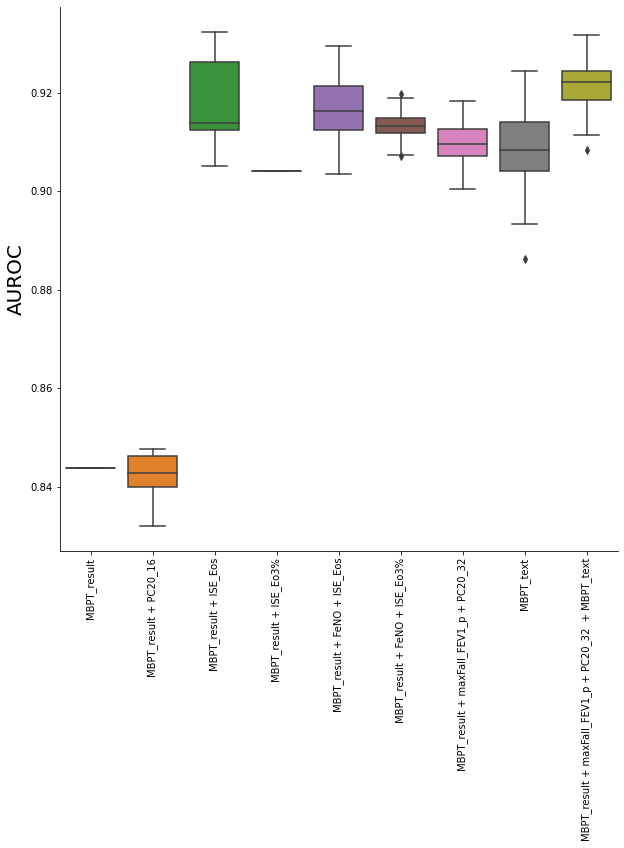

In [66]:
from itertools import combinations
from statannot import add_stat_annotation
import seaborn as sns

plt.figure(figsize=(10,10))
x = 'variable'
y = 'test_auroc'
order = ['MBPT_result', 'MBPT_result + PC20_16', 'MBPT_result + ISE_Eos', 
         'MBPT_result + ISE_Eo3%', 'MBPT_result + FeNO + ISE_Eos', 
         'MBPT_result + FeNO + ISE_Eo3%', "MBPT_result + maxFall_FEV1_p + PC20_32",
         "MBPT_text", "MBPT_result + maxFall_FEV1_p + PC20_32  + MBPT_text"]

combination = combinations(order, 2)
ax = sns.boxplot(data=metrics, x=x, y=y, order=order)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# plt.ylim(0.89, 0.95)
plt.xlabel("")
plt.ylabel('AUROC', fontsize=20)
sns.despine()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

MBPT_result v.s. MBPT_result + PC20_16: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=1.817e+00
MBPT_result + PC20_16 v.s. MBPT_result + ISE_Eos: t-test independent samples with Bonferroni correction, P_val=6.485e-163 stat=-9.205e+01
MBPT_result + ISE_Eos v.s. MBPT_result + ISE_Eo3%: t-test independent samples with Bonferroni correction, P_val=3.872e-47 stat=1.975e+01
MBPT_result + ISE_Eo3% v.s. MBPT_result + FeNO + ISE_Eos: t-test independent samples with Bonferroni correction, P_val=2.305e-52 stat=-2.159e+01
MBPT_result + FeNO + ISE_Eos v.s. MBPT_result + FeNO + ISE_Eo3%: t-test independent samples with Bonferroni correction, P_val=2.092e-05 stat=5.166e+00
MBPT_result + FeNO + ISE_Eo3% v.s. MBPT_result + maxFall_FEV1_p + PC20_32: t-test independent samples with Bonferroni correction, P_val=1.4

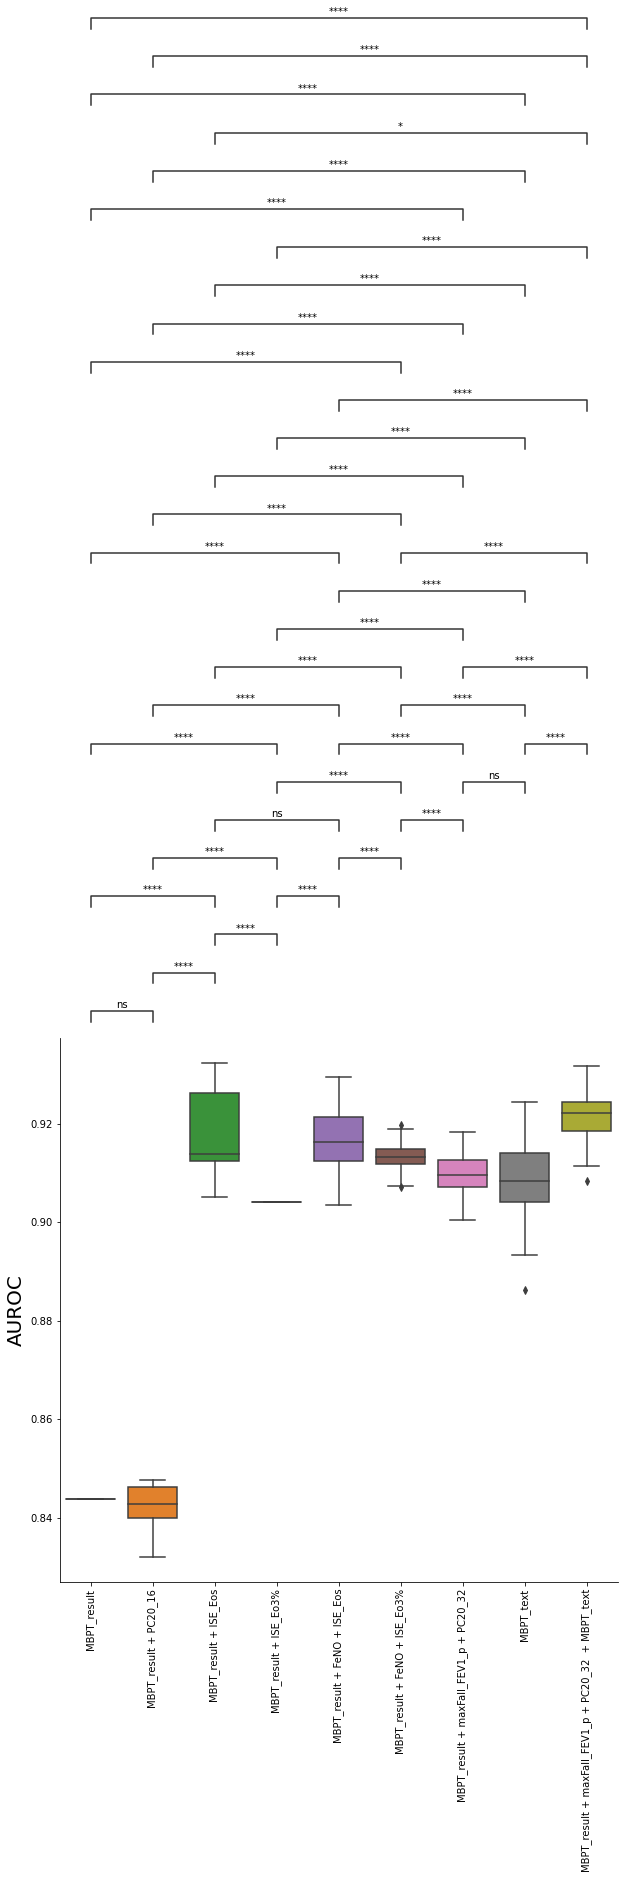

In [60]:
from itertools import combinations
from statannot import add_stat_annotation
import seaborn as sns

plt.figure(figsize=(10,10))
x = 'variable'
y = 'test_auroc'
order = ['MBPT_result', 'MBPT_result + PC20_16', 'MBPT_result + ISE_Eos', 
         'MBPT_result + ISE_Eo3%', 'MBPT_result + FeNO + ISE_Eos', 
         'MBPT_result + FeNO + ISE_Eo3%', "MBPT_result + maxFall_FEV1_p + PC20_32",
         "MBPT_text", "MBPT_result + maxFall_FEV1_p + PC20_32  + MBPT_text"]

combination = combinations(order, 2)
ax = sns.boxplot(data=metrics, x=x, y=y, order=order)

ax, test_results = add_stat_annotation(ax, data=metrics, x=x, y=y, order=order,
                                   box_pairs=combination,
                                   test='t-test_ind', text_format='star', loc='outside', verbose=2)


ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# plt.ylim(0.89, 0.95)
plt.xlabel("")
plt.ylabel('AUROC', fontsize=20)
sns.despine()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

MBPT_result v.s. MBPT_result + PC20_16: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=3.894e-01
MBPT_result + PC20_16 v.s. MBPT_result + ISE_Eos: t-test independent samples with Bonferroni correction, P_val=5.066e-157 stat=-8.581e+01
MBPT_result + ISE_Eos v.s. MBPT_result + ISE_Eo3%: t-test independent samples with Bonferroni correction, P_val=1.317e-138 stat=6.877e+01
MBPT_result + ISE_Eo3% v.s. MBPT_result + FeNO + ISE_Eos: t-test independent samples with Bonferroni correction, P_val=2.136e-180 stat=-1.132e+02
MBPT_result + FeNO + ISE_Eos v.s. MBPT_result + FeNO + ISE_Eo3%: t-test independent samples with Bonferroni correction, P_val=1.743e-48 stat=2.022e+01
MBPT_result + FeNO + ISE_Eo3% v.s. MBPT_result + maxFall_FEV1_p + PC20_32: t-test independent samples with Bonferroni correction, P_val=2

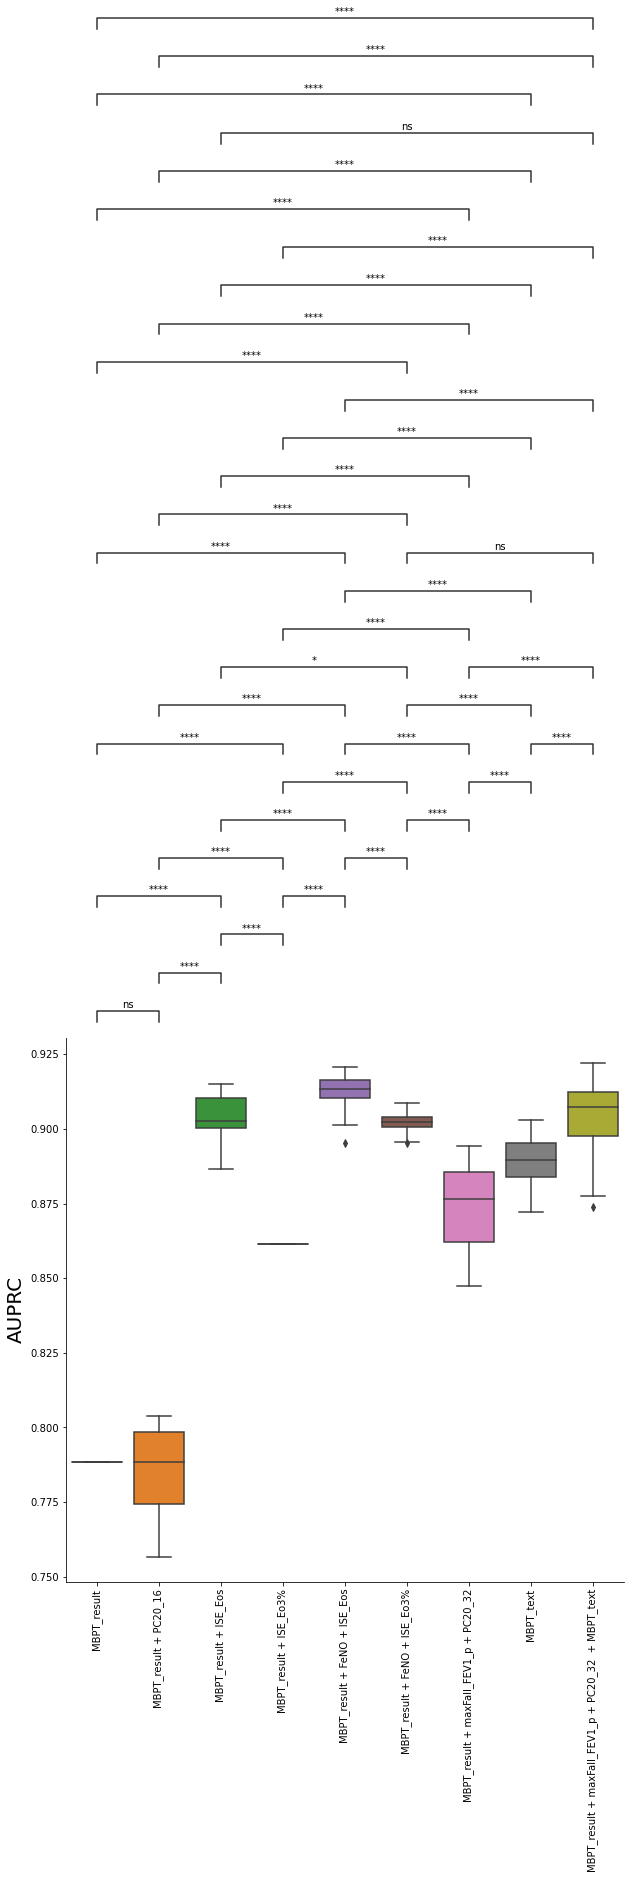

In [61]:
from itertools import combinations
from statannot import add_stat_annotation
import seaborn as sns

plt.figure(figsize=(10,10))
x = 'variable'
y = 'test_auprc'
order = ['MBPT_result', 'MBPT_result + PC20_16', 'MBPT_result + ISE_Eos', 
         'MBPT_result + ISE_Eo3%', 'MBPT_result + FeNO + ISE_Eos', 
         'MBPT_result + FeNO + ISE_Eo3%', "MBPT_result + maxFall_FEV1_p + PC20_32",
         "MBPT_text", "MBPT_result + maxFall_FEV1_p + PC20_32  + MBPT_text"]

combination = combinations(order, 2)
ax = sns.boxplot(data=metrics, x=x, y=y, order=order)

ax, test_results = add_stat_annotation(ax, data=metrics, x=x, y=y, order=order,
                                   box_pairs=combination,
                                   test='t-test_ind', text_format='star', loc='outside', verbose=2)


ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# plt.ylim(0.89, 0.95)
plt.xlabel("")
plt.ylabel('AUPRC', fontsize=20)
sns.despine()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

MBPT_result v.s. MBPT_result + PC20_16: t-test independent samples with Bonferroni correction, P_val=2.987e-83 stat=-3.410e+01
MBPT_result + PC20_16 v.s. MBPT_result + ISE_Eos: t-test independent samples with Bonferroni correction, P_val=1.450e-163 stat=9.277e+01
MBPT_result + ISE_Eos v.s. MBPT_result + ISE_Eo3%: t-test independent samples with Bonferroni correction, P_val=1.695e-46 stat=-1.953e+01
MBPT_result + ISE_Eo3% v.s. MBPT_result + FeNO + ISE_Eos: t-test independent samples with Bonferroni correction, P_val=3.888e-06 stat=5.515e+00
MBPT_result + FeNO + ISE_Eos v.s. MBPT_result + FeNO + ISE_Eo3%: t-test independent samples with Bonferroni correction, P_val=2.012e-19 stat=-1.057e+01
MBPT_result + FeNO + ISE_Eo3% v.s. MBPT_result + maxFall_FEV1_p + PC20_32: t-test independent samples with Bonferroni correction, P_val=9.

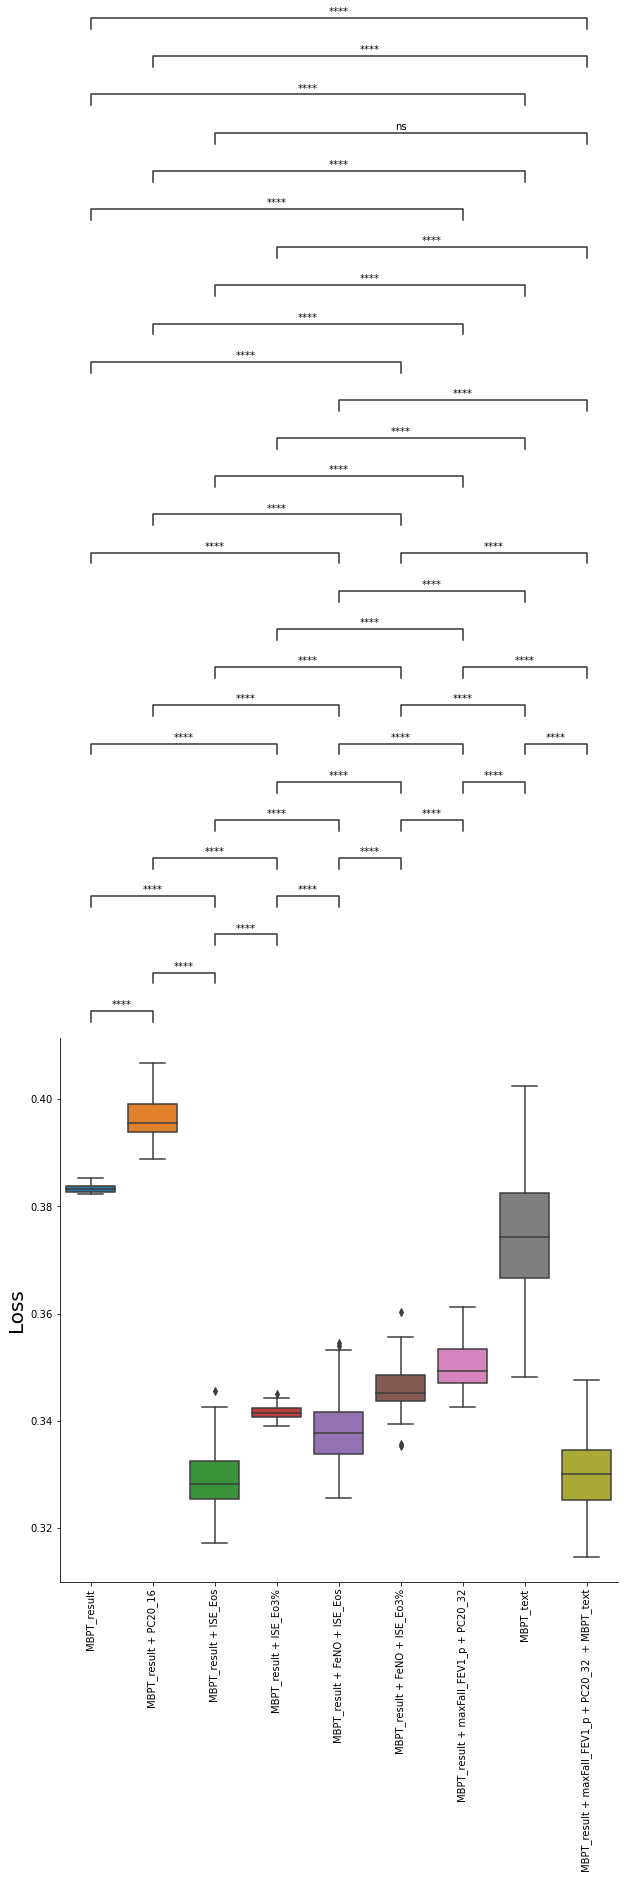

In [62]:
from itertools import combinations
from statannot import add_stat_annotation
import seaborn as sns

plt.figure(figsize=(10,10))
x = 'variable'
y = 'test_mse_loss'
order = ['MBPT_result', 'MBPT_result + PC20_16', 'MBPT_result + ISE_Eos', 
         'MBPT_result + ISE_Eo3%', 'MBPT_result + FeNO + ISE_Eos', 
         'MBPT_result + FeNO + ISE_Eo3%', "MBPT_result + maxFall_FEV1_p + PC20_32",
         "MBPT_text", "MBPT_result + maxFall_FEV1_p + PC20_32  + MBPT_text"]

combination = combinations(order, 2)
ax = sns.boxplot(data=metrics, x=x, y=y, order=order)

ax, test_results = add_stat_annotation(ax, data=metrics, x=x, y=y, order=order,
                                   box_pairs=combination,
                                   test='t-test_ind', text_format='star', loc='outside', verbose=2)


ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# plt.ylim(0.89, 0.95)
plt.xlabel("")
plt.ylabel('Loss', fontsize=20)
sns.despine()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

MBPT_result v.s. MBPT_result + PC20_16: t-test independent samples with Bonferroni correction, P_val=8.067e-46 stat=1.930e+01
MBPT_result + PC20_16 v.s. MBPT_result + ISE_Eos: t-test independent samples with Bonferroni correction, P_val=9.024e-20 stat=-1.068e+01
MBPT_result + ISE_Eos v.s. MBPT_result + ISE_Eo3%: t-test independent samples with Bonferroni correction, P_val=1.091e-05 stat=5.303e+00
MBPT_result + ISE_Eo3% v.s. MBPT_result + FeNO + ISE_Eos: t-test independent samples with Bonferroni correction, P_val=2.159e-11 stat=-7.709e+00
MBPT_result + FeNO + ISE_Eos v.s. MBPT_result + FeNO + ISE_Eo3%: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=1.259e+00
MBPT_result + FeNO + ISE_Eo3% v.s. MBPT_result + maxFall_FEV1_p + PC20_32: t-test independent samples with Bonferroni correction, P_val=3.54

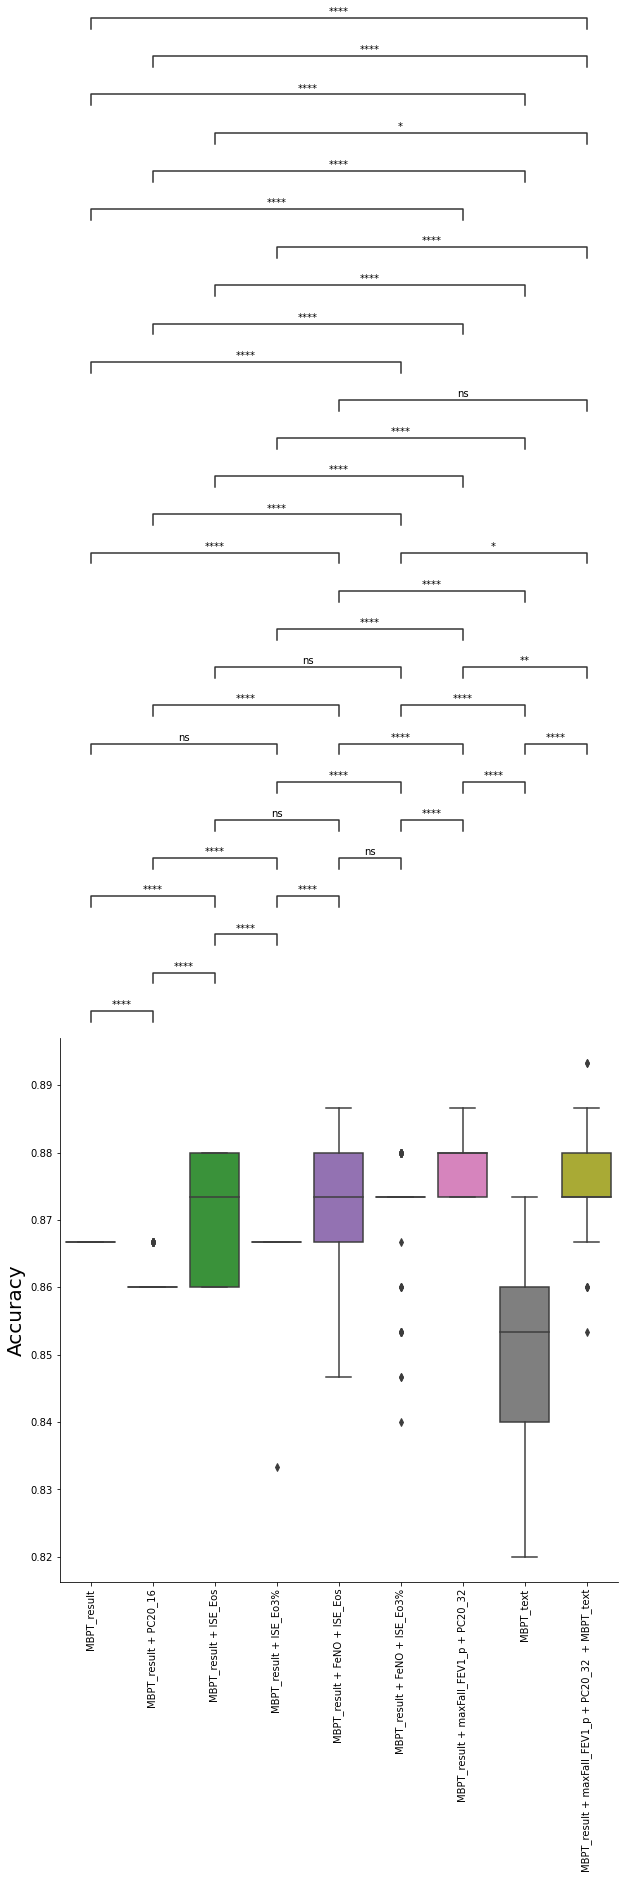

In [63]:
from itertools import combinations
from statannot import add_stat_annotation
import seaborn as sns

plt.figure(figsize=(10,10))
x = 'variable'
y = 'test_scores'
order = ['MBPT_result', 'MBPT_result + PC20_16', 'MBPT_result + ISE_Eos', 
         'MBPT_result + ISE_Eo3%', 'MBPT_result + FeNO + ISE_Eos', 
         'MBPT_result + FeNO + ISE_Eo3%', "MBPT_result + maxFall_FEV1_p + PC20_32",
         "MBPT_text", "MBPT_result + maxFall_FEV1_p + PC20_32  + MBPT_text"]

combination = combinations(order, 2)
ax = sns.boxplot(data=metrics, x=x, y=y, order=order)

ax, test_results = add_stat_annotation(ax, data=metrics, x=x, y=y, order=order,
                                   box_pairs=combination,
                                   test='t-test_ind', text_format='star', loc='outside', verbose=2)


ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# plt.ylim(0.89, 0.95)
plt.xlabel("")
plt.ylabel('Accuracy', fontsize=20)
sns.despine()

In [65]:
metrics.to_excel('metrics.xlsx', index=False)